In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

print(tf.__version__)

2024-01-31 10:06:34.270692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 10:06:34.270721: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 10:06:34.271421: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 10:06:34.320322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 10:06:35.095955: W tensorflow/compiler/

2.14.0


In [3]:
import keras_tuner as kt
from datetime import datetime

In [4]:
from eggman.grid import luminosity, log_surface_gravity, calculate_eep, metallicity

In [5]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/dataset.h5"
train = pd.read_hdf(filename, "train")
train.head()

,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,...,log_Teff,log_radius,log_Dnu_freq_o,log_star_mass,log_g,log_L,delta_X,f_nuc,phase,EEP
4239372,1084,272,1.19292,0.268233,0.007538,2.488300,0.000000,0.006041,4.203466e+09,2.499008,...,3.756668,0.397768,1.577576,0.076611,3.719144,0.776902,0.724229,1.013812,0,0.271755
4364990,1240,59,0.91167,0.244405,0.001755,1.542206,0.000000,0.006041,3.569699e+09,0.984808,...,3.795451,-0.006648,2.109143,-0.040162,4.411202,0.123200,0.367104,0.999825,0,0.083324
3633770,5326,429,1.66118,0.260537,0.006578,1.536823,0.011188,0.006041,1.381822e+09,2.300057,...,3.913624,0.361739,1.657543,0.220417,3.935007,1.332668,0.732880,1.072159,0,0.229643
5992731,4261,777,2.13472,0.227242,0.022099,1.757880,0.015893,0.006041,1.389514e+09,5.653303,...,3.685023,0.752302,1.171580,0.329341,3.262804,1.199392,0.750659,1.074809,0,0.513249
3832114,5574,553,1.75181,0.282216,0.004477,2.507526,0.012875,0.006041,9.558198e+08,2.896064,...,3.921971,0.461808,1.514518,0.243487,3.757938,1.566193,0.713306,1.008049,0,0.256022


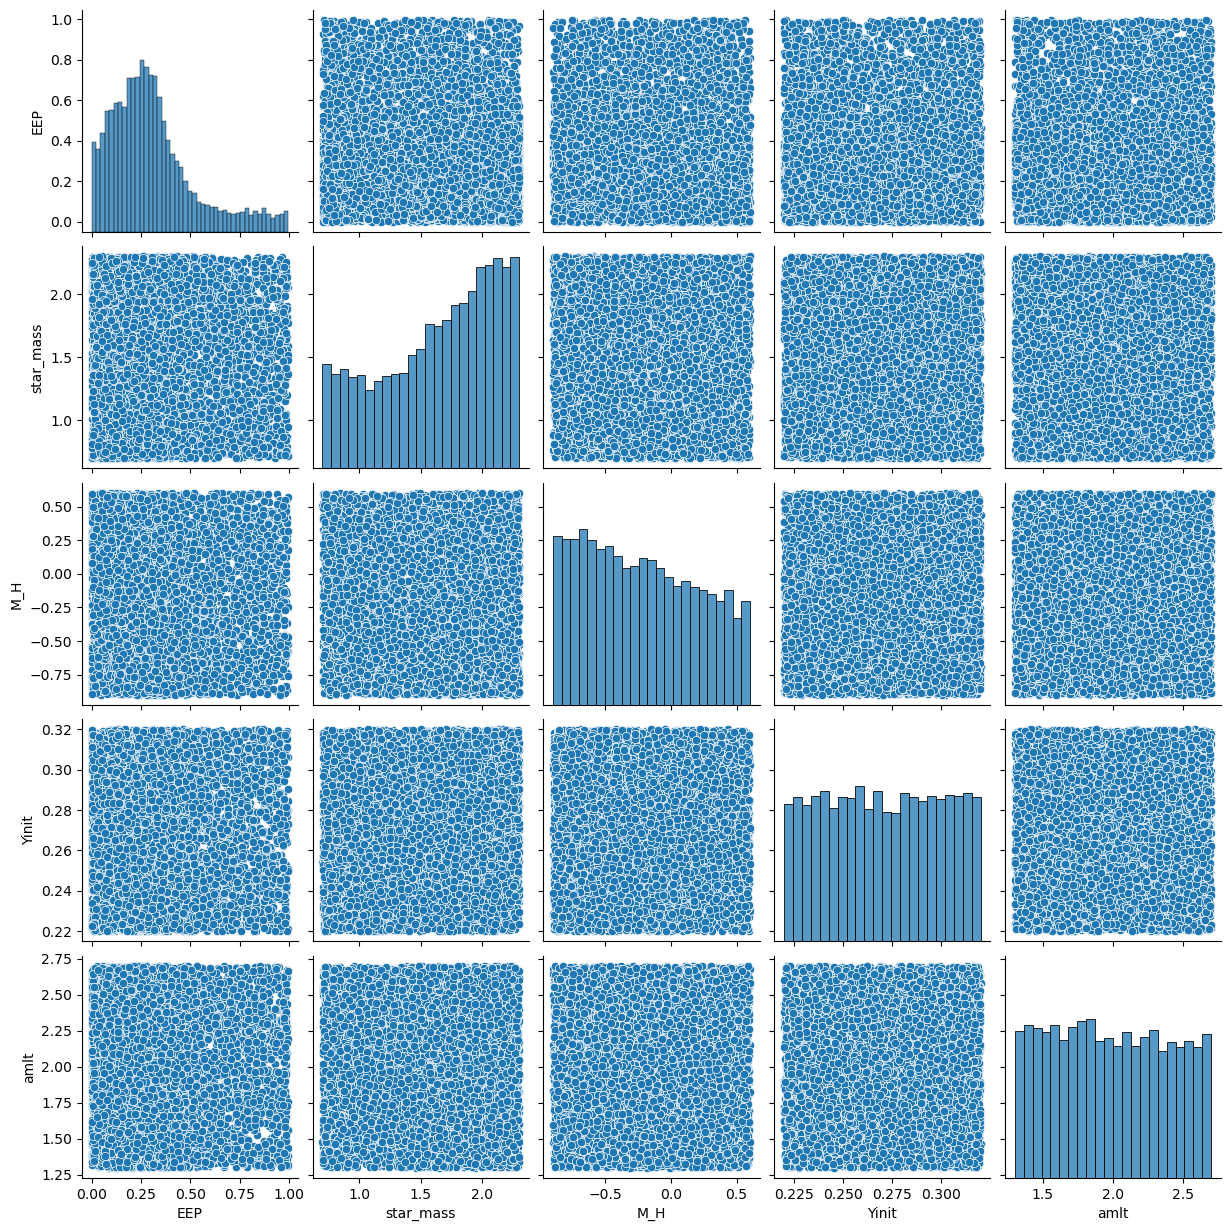

In [10]:
features = ["EEP", "star_mass", "M_H", "Yinit", "amlt"]
sns.pairplot(train.sample(10000), vars=features);

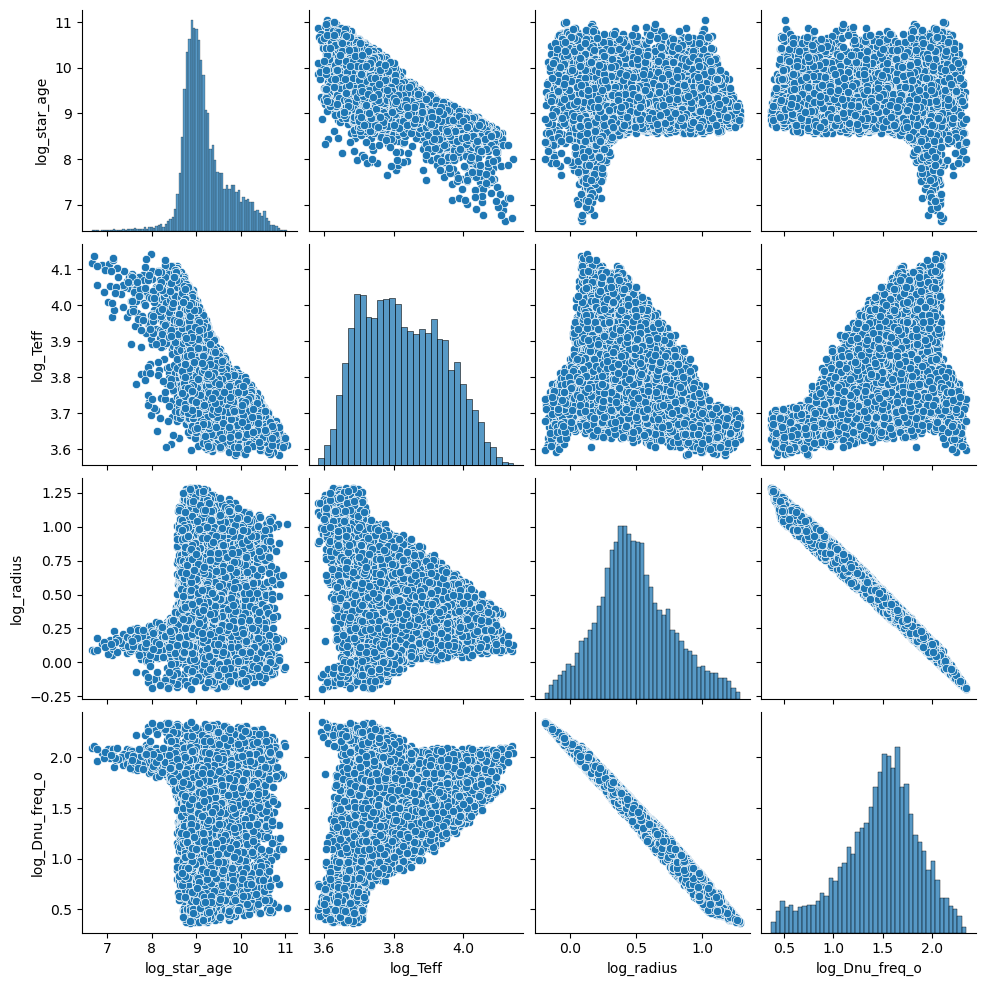

In [14]:
labels = ["log_star_age", "log_Teff", "log_radius", "log_Dnu_freq_o"]
sns.pairplot(train.sample(10000), vars=labels);

In [15]:
train_features = train[features].astype(np.float32).copy()
train_labels = train[labels].astype(np.float32).copy()

In [16]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features), batch_size=len(train_features))

2024-01-31 10:10:04.921830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18112 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2024-01-31 10:10:04.922526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18447 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


We want to ensure the outputs are scaled to common target loss.

Target for log_Teff is 0.0002 * ln(10)

Target for log_radius is 0.0002 * ln(10)

Target for log_star_age is 0.002 * ln(10)

Target for log_Dnu is 0.0002 * ln(10)

If we put all on the same scale, we should reduce the scale of outputs which could be a bottleneck.

In [75]:
scale_factor = 0.002 / 0.0002

In [76]:
scale_factor

10.0

In [68]:
ln10 = np.log(10)
s_log_Teff = 0.0002 * ln10
s_log_radius = 0.0002 * ln10

In [69]:
s_log_lum = np.sqrt(4 * s_log_radius**2 + 16 * s_log_Teff**2)
print(s_log_lum)

0.0020594947167649445


In [70]:
s_bol_mag = 2.5 * s_log_lum
s_bol_mag

0.005148736791912361

In [77]:
label_offset = train_labels.mean().to_numpy()
label_scale = train_labels.std().to_numpy()

rescaler = layers.Rescaling(label_scale, offset=label_offset)

In [78]:
num_features = len(features)
num_labels = len(labels)

In [134]:
class HyperModel(kt.HyperModel):
    def __init__(self, *args, max_iter=40000, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_iter = max_iter
        self.batch_size = None
        self.shuffle = False
        self.initial_learning_rate = 1e-3
        self.final_learning_rate = 1e-6
        self.learning_rate_decay = None

    def build(self, hp):
        # self.batch_size = hp.Choice("batch_size", values=[2**i for i in range(10, 18, 2)])
        self.batch_size = 1024
        # self.shuffle = hp.Boolean("shuffle")

        # units = hp.Choice('units_per_layer', values=[2**i for i in range(6, 10)])
        units = 128
        # num_layers = hp.Int("hidden_layers", min_value=4, max_value=8, step=2)
        num_layers = 6
        activation = "relu"

        # l2_reg = hp.Choice('l2_reg', values=[1e-6, 1e-8, 0.0])
        l2_reg = 1e-8
        kernel_regularizer = tf.keras.regularizers.L2(l2_reg)

        model = tf.keras.Sequential(
            [normalizer] +
            [layers.Dense(units, activation, kernel_regularizer=kernel_regularizer) for _ in range(num_layers)] +
            [layers.Dense(num_labels, kernel_regularizer=kernel_regularizer), rescaler]
        )

        self.learning_rate_decay = hp.Choice('learning_rate_decay', values=[1e-2, 1e-1, 1.])

        opt = optimizers.Adam(learning_rate=self.initial_learning_rate)
        loss = 'mean_squared_error'

        model.compile(opt, loss=loss)
        return model

    def fit(self, hp, model, x, y, stop_early=True, monitor="val_loss", **kwargs):
        validation_split = kwargs.pop("validation_split", 0.0)
        epochs = kwargs.pop(
            "epochs",
            int(self.max_iter * self.batch_size / (1 - validation_split) / x.shape[0]) + 1
        )

        cbs = kwargs.pop("callbacks", [])
        if stop_early and not any(isinstance(cb, callbacks.EarlyStopping) for cb in cbs):
            patience = max(2, int(0.1*epochs))
            min_delta = 1e-6
            # need to check what value of min_delta to use
            early_stopping = callbacks.EarlyStopping(monitor=monitor, patience=patience, min_delta=min_delta)
            cbs.append(early_stopping)

        
        # learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        def learning_rate_scheduler(_, learning_rate):
            if learning_rate < self.final_learning_rate:
                return learning_rate
            return learning_rate * tf.math.exp(- self.learning_rate_decay)

        cbs.append(callbacks.LearningRateScheduler(learning_rate_scheduler))

        return model.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=self.batch_size,
            validation_split=validation_split,
            shuffle=self.shuffle,
            callbacks=cbs,
            **kwargs,
        )

In [135]:
epoch = np.arange(51)
alpha = np.array([1e-2, 1e-1, 1])
lr = 1e-3 * np.ones(epoch.shape + alpha.shape)
lr_min = 1e-6
for i in epoch[1:]:
    condition = lr[i-1] < lr_min
    lr[i] = np.where(condition, lr[i-1], lr[i-1] * np.exp(-alpha))


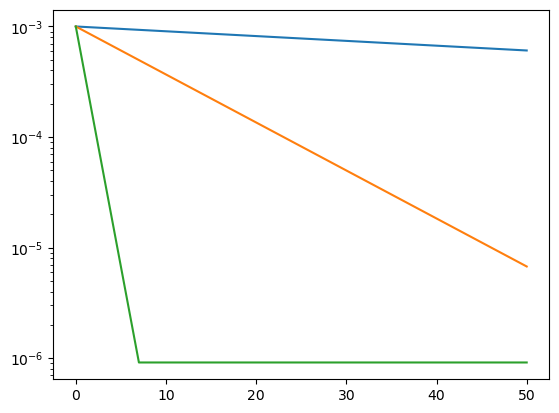

In [136]:
plt.plot(epoch, lr)
plt.yscale("log")

In [137]:
hypermodel = HyperModel(max_iter=200000)

In [138]:
directory = '/mnt/data-storage/stellar-emulator/tuning'
project_name = datetime.now().strftime("%Y%m%d-%H%M%S")
# project_name = "20231126-134236"

In [139]:
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=3,
    directory=directory,
#     overwrite=True,
    project_name=project_name,
)

In [140]:
tboard = callbacks.TensorBoard(f'/mnt/data-storage/stellar-emulator/tuning/{project_name}/logs')

In [141]:
tuner.search(
    train_features,
    train_labels,
    validation_split=0.2,
    callbacks=[tboard],
    stop_early=False,
)

Trial 3 Complete [00h 15m 57s]
val_loss: 0.00016004781355150044

Best val_loss So Far: 3.4360127756372094e-05
Total elapsed time: 00h 47m 54s
INFO:tensorflow:Oracle triggered exit


In [162]:
best_hp = tuner.get_best_hyperparameters(num_trials=10)  # <-- choose 'best'
print(best_hp[1].values)

{'learning_rate_decay': 0.01}


In [163]:
# hp = kt.HyperParameters()
# hp.values = {'l2_reg': 1e-08}
hp = best_hp[1]
best_model = tuner.hypermodel.build(hp)

In [164]:
# best_model = tf.keras.models.load_model(os.path.join(directory, project_name, "best_trial/checkpoint"))
# best_model.summary()

In [165]:
best_directory = os.path.join(directory, project_name, "best_trial")
if not os.path.exists(best_directory):
    os.makedirs(best_directory)

In [166]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(best_directory, "checkpoint"),
    monitor="loss",
    save_best_only=True,
)

In [167]:
tboard = callbacks.TensorBoard(os.path.join(best_directory, "logs"))

In [168]:
history = hypermodel.fit(
    hp,
    best_model,
    train_features, 
    train_labels,
    validation_split=0.0,
    stop_early=False,
    epochs=5000,
    initial_epoch=0,
    callbacks=[model_checkpoint, tboard],
)

Epoch 1/5000
4861/4867 [============================>.] - ETA: 0s - loss: 0.0011INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 0.0011 - lr: 9.9005e-04
Epoch 2/5000
4859/4867 [============================>.] - ETA: 0s - loss: 3.0695e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.0721e-04 - lr: 9.8020e-04
Epoch 3/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.2610e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2611e-04 - lr: 9.7045e-04
Epoch 4/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.8666e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8672e-04 - lr: 9.6079e-04
Epoch 5/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.6186e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6185e-04 - lr: 9.5123e-04
Epoch 6/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.4752e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.4748e-04 - lr: 9.4176e-04
Epoch 7/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.3687e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.3687e-04 - lr: 9.3239e-04
Epoch 8/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.2679e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.2678e-04 - lr: 9.2312e-04
Epoch 9/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.1897e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 19s 4ms/step - loss: 1.1897e-04 - lr: 9.1393e-04
Epoch 10/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.1192e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.1186e-04 - lr: 9.0484e-04
Epoch 11/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.0753e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 18s 4ms/step - loss: 1.0752e-04 - lr: 8.9583e-04
Epoch 12/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.0207e-04INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.0206e-04 - lr: 8.8692e-04
Epoch 13/5000
4863/4867 [============================>.] - ETA: 0s - loss: 9.7835e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 19s 4ms/step - loss: 9.7821e-05 - lr: 8.7810e-04
Epoch 14/5000
4867/4867 [==============================] - ETA: 0s - loss: 9.4188e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 9.4188e-05 - lr: 8.6936e-04
Epoch 15/5000
4862/4867 [============================>.] - ETA: 0s - loss: 9.0548e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 9.0532e-05 - lr: 8.6071e-04
Epoch 16/5000
4862/4867 [============================>.] - ETA: 0s - loss: 8.7946e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 8.7926e-05 - lr: 8.5214e-04
Epoch 17/5000
4865/4867 [============================>.] - ETA: 0s - loss: 8.6180e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 8.6173e-05 - lr: 8.4366e-04
Epoch 18/5000
4859/4867 [============================>.] - ETA: 0s - loss: 8.3122e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 8.3112e-05 - lr: 8.3527e-04
Epoch 19/5000
4864/4867 [============================>.] - ETA: 0s - loss: 8.1920e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 8.1908e-05 - lr: 8.2696e-04
Epoch 20/5000
4864/4867 [============================>.] - ETA: 0s - loss: 8.0175e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 8.0172e-05 - lr: 8.1873e-04
Epoch 21/5000
4861/4867 [============================>.] - ETA: 0s - loss: 7.8737e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 7.8746e-05 - lr: 8.1058e-04
Epoch 22/5000
4863/4867 [============================>.] - ETA: 0s - loss: 7.6891e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 7.6899e-05 - lr: 8.0252e-04
Epoch 23/5000
4862/4867 [============================>.] - ETA: 0s - loss: 7.5201e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 7.5198e-05 - lr: 7.9453e-04
Epoch 24/5000
4863/4867 [============================>.] - ETA: 0s - loss: 7.2902e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 7.2896e-05 - lr: 7.8663e-04
Epoch 25/5000
4863/4867 [============================>.] - ETA: 0s - loss: 7.2059e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 7.2055e-05 - lr: 7.7880e-04
Epoch 26/5000
4859/4867 [============================>.] - ETA: 0s - loss: 7.0857e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 7.0868e-05 - lr: 7.7105e-04
Epoch 27/5000
4855/4867 [============================>.] - ETA: 0s - loss: 6.9272e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 19s 4ms/step - loss: 6.9292e-05 - lr: 7.6338e-04
Epoch 28/5000
4855/4867 [============================>.] - ETA: 0s - loss: 6.8625e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 6.8597e-05 - lr: 7.5578e-04
Epoch 29/5000
4856/4867 [============================>.] - ETA: 0s - loss: 6.6954e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 6.6932e-05 - lr: 7.4826e-04
Epoch 30/5000
4867/4867 [==============================] - ETA: 0s - loss: 6.5624e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 6.5624e-05 - lr: 7.4082e-04
Epoch 31/5000
4867/4867 [==============================] - ETA: 0s - loss: 6.5218e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 6.5218e-05 - lr: 7.3345e-04
Epoch 32/5000
4859/4867 [============================>.] - ETA: 0s - loss: 6.3689e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 6.3692e-05 - lr: 7.2615e-04
Epoch 33/5000
4863/4867 [============================>.] - ETA: 0s - loss: 6.2582e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 6.2579e-05 - lr: 7.1892e-04
Epoch 34/5000
4861/4867 [============================>.] - ETA: 0s - loss: 6.1992e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 6.1988e-05 - lr: 7.1177e-04
Epoch 35/5000
4862/4867 [============================>.] - ETA: 0s - loss: 6.0404e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 6.0402e-05 - lr: 7.0469e-04
Epoch 36/5000
4859/4867 [============================>.] - ETA: 0s - loss: 5.9708e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 5.9728e-05 - lr: 6.9768e-04
Epoch 37/5000
4866/4867 [============================>.] - ETA: 0s - loss: 5.9561e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 5.9559e-05 - lr: 6.9073e-04
Epoch 38/5000
4855/4867 [============================>.] - ETA: 0s - loss: 5.8860e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 5.8877e-05 - lr: 6.8386e-04
Epoch 39/5000
4864/4867 [============================>.] - ETA: 0s - loss: 5.7785e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 5.7788e-05 - lr: 6.7706e-04
Epoch 40/5000
4862/4867 [============================>.] - ETA: 0s - loss: 5.7421e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 5.7427e-05 - lr: 6.7032e-04
Epoch 41/5000
4863/4867 [============================>.] - ETA: 0s - loss: 5.6257e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 5.6267e-05 - lr: 6.6365e-04
Epoch 42/5000
4863/4867 [============================>.] - ETA: 0s - loss: 5.5965e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 5.5977e-05 - lr: 6.5705e-04
Epoch 43/5000
4854/4867 [============================>.] - ETA: 0s - loss: 5.5605e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 5.5616e-05 - lr: 6.5051e-04
Epoch 44/5000
4855/4867 [============================>.] - ETA: 0s - loss: 5.4635e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 5.4638e-05 - lr: 6.4404e-04
Epoch 45/5000
4855/4867 [============================>.] - ETA: 0s - loss: 5.4377e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 19s 4ms/step - loss: 5.4367e-05 - lr: 6.3763e-04
Epoch 46/5000
4867/4867 [==============================] - 19s 4ms/step - loss: 5.4559e-05 - lr: 6.3128e-04
Epoch 47/5000
4866/4867 [============================>.] - ETA: 0s - loss: 5.2988e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 5.2987e-05 - lr: 6.2500e-04
Epoch 48/5000
4858/4867 [============================>.] - ETA: 0s - loss: 5.2656e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 5.2670e-05 - lr: 6.1878e-04
Epoch 49/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 5.2966e-05 - lr: 6.1263e-04
Epoch 50/5000
4861/4867 [============================>.] - ETA: 0s - loss: 5.1791e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 5.1795e-05 - lr: 6.0653e-04
Epoch 51/5000
4859/4867 [============================>.] - ETA: 0s - loss: 5.1078e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 5.1105e-05 - lr: 6.0050e-04
Epoch 52/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 5.1436e-05 - lr: 5.9452e-04
Epoch 53/5000
4861/4867 [============================>.] - ETA: 0s - loss: 4.9993e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.9999e-05 - lr: 5.8861e-04
Epoch 54/5000
4867/4867 [==============================] - 20s 4ms/step - loss: 5.0321e-05 - lr: 5.8275e-04
Epoch 55/5000
4858/4867 [============================>.] - ETA: 0s - loss: 4.9955e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 4.9977e-05 - lr: 5.7695e-04
Epoch 56/5000
4861/4867 [============================>.] - ETA: 0s - loss: 4.9170e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 4.9175e-05 - lr: 5.7121e-04
Epoch 57/5000
4866/4867 [============================>.] - ETA: 0s - loss: 4.8553e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.8553e-05 - lr: 5.6553e-04
Epoch 58/5000
4861/4867 [============================>.] - ETA: 0s - loss: 4.8198e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 4.8200e-05 - lr: 5.5990e-04
Epoch 59/5000
4858/4867 [============================>.] - ETA: 0s - loss: 4.8091e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 4.8099e-05 - lr: 5.5433e-04
Epoch 60/5000
4866/4867 [============================>.] - ETA: 0s - loss: 4.6889e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.6889e-05 - lr: 5.4881e-04
Epoch 61/5000
4867/4867 [==============================] - 20s 4ms/step - loss: 4.7064e-05 - lr: 5.4335e-04
Epoch 62/5000
4867/4867 [==============================] - ETA: 0s - loss: 4.6718e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.6718e-05 - lr: 5.3794e-04
Epoch 63/5000
4859/4867 [============================>.] - ETA: 0s - loss: 4.5933e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.5945e-05 - lr: 5.3259e-04
Epoch 64/5000
4862/4867 [============================>.] - ETA: 0s - loss: 4.5488e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.5488e-05 - lr: 5.2729e-04
Epoch 65/5000
4858/4867 [============================>.] - ETA: 0s - loss: 4.5394e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.5401e-05 - lr: 5.2205e-04
Epoch 66/5000
4863/4867 [============================>.] - ETA: 0s - loss: 4.5188e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 4.5194e-05 - lr: 5.1685e-04
Epoch 67/5000
4858/4867 [============================>.] - ETA: 0s - loss: 4.4994e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.4996e-05 - lr: 5.1171e-04
Epoch 68/5000
4860/4867 [============================>.] - ETA: 0s - loss: 4.4305e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.4304e-05 - lr: 5.0662e-04
Epoch 69/5000
4859/4867 [============================>.] - ETA: 0s - loss: 4.4047e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.4047e-05 - lr: 5.0158e-04
Epoch 70/5000
4864/4867 [============================>.] - ETA: 0s - loss: 4.3372e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 4.3375e-05 - lr: 4.9659e-04
Epoch 71/5000
4860/4867 [============================>.] - ETA: 0s - loss: 4.3309e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.3309e-05 - lr: 4.9164e-04
Epoch 72/5000
4867/4867 [==============================] - ETA: 0s - loss: 4.3123e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 4.3123e-05 - lr: 4.8675e-04
Epoch 73/5000
4860/4867 [============================>.] - ETA: 0s - loss: 4.2551e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 4.2552e-05 - lr: 4.8191e-04
Epoch 74/5000
4862/4867 [============================>.] - ETA: 0s - loss: 4.2212e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.2214e-05 - lr: 4.7711e-04
Epoch 75/5000
4864/4867 [============================>.] - ETA: 0s - loss: 4.1897e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.1900e-05 - lr: 4.7237e-04
Epoch 76/5000
4864/4867 [============================>.] - ETA: 0s - loss: 4.1738e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.1740e-05 - lr: 4.6767e-04
Epoch 77/5000
4861/4867 [============================>.] - ETA: 0s - loss: 4.1194e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.1195e-05 - lr: 4.6301e-04
Epoch 78/5000
4866/4867 [============================>.] - ETA: 0s - loss: 4.1000e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.0999e-05 - lr: 4.5841e-04
Epoch 79/5000
4866/4867 [============================>.] - ETA: 0s - loss: 4.0734e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.0733e-05 - lr: 4.5384e-04
Epoch 80/5000
4865/4867 [============================>.] - ETA: 0s - loss: 4.0185e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 4.0186e-05 - lr: 4.4933e-04
Epoch 81/5000
4860/4867 [============================>.] - ETA: 0s - loss: 3.9947e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.9946e-05 - lr: 4.4486e-04
Epoch 82/5000
4861/4867 [============================>.] - ETA: 0s - loss: 3.9877e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 3.9874e-05 - lr: 4.4043e-04
Epoch 83/5000
4863/4867 [============================>.] - ETA: 0s - loss: 3.9711e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.9713e-05 - lr: 4.3605e-04
Epoch 84/5000
4866/4867 [============================>.] - ETA: 0s - loss: 3.9107e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 3.9106e-05 - lr: 4.3171e-04
Epoch 85/5000
4857/4867 [============================>.] - ETA: 0s - loss: 3.8983e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 3.8997e-05 - lr: 4.2742e-04
Epoch 86/5000
4859/4867 [============================>.] - ETA: 0s - loss: 3.8934e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.8940e-05 - lr: 4.2316e-04
Epoch 87/5000
4858/4867 [============================>.] - ETA: 0s - loss: 3.8266e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.8274e-05 - lr: 4.1895e-04
Epoch 88/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 3.8423e-05 - lr: 4.1478e-04
Epoch 89/5000
4859/4867 [============================>.] - ETA: 0s - loss: 3.7938e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.7944e-05 - lr: 4.1066e-04
Epoch 90/5000
4867/4867 [==============================] - ETA: 0s - loss: 3.7912e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.7912e-05 - lr: 4.0657e-04
Epoch 91/5000
4860/4867 [============================>.] - ETA: 0s - loss: 3.7257e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.7258e-05 - lr: 4.0252e-04
Epoch 92/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 3.7280e-05 - lr: 3.9852e-04
Epoch 93/5000
4863/4867 [============================>.] - ETA: 0s - loss: 3.6713e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.6715e-05 - lr: 3.9455e-04
Epoch 94/5000
4856/4867 [============================>.] - ETA: 0s - loss: 3.6476e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.6486e-05 - lr: 3.9063e-04
Epoch 95/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 3.6520e-05 - lr: 3.8674e-04
Epoch 96/5000
4865/4867 [============================>.] - ETA: 0s - loss: 3.6131e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.6131e-05 - lr: 3.8289e-04
Epoch 97/5000
4860/4867 [============================>.] - ETA: 0s - loss: 3.6024e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.6028e-05 - lr: 3.7908e-04
Epoch 98/5000
4864/4867 [============================>.] - ETA: 0s - loss: 3.5767e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.5767e-05 - lr: 3.7531e-04
Epoch 99/5000
4865/4867 [============================>.] - ETA: 0s - loss: 3.5531e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 3.5530e-05 - lr: 3.7158e-04
Epoch 100/5000
4863/4867 [============================>.] - ETA: 0s - loss: 3.5487e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.5488e-05 - lr: 3.6788e-04
Epoch 101/5000
4867/4867 [==============================] - ETA: 0s - loss: 3.4987e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.4987e-05 - lr: 3.6422e-04
Epoch 102/5000
4867/4867 [==============================] - ETA: 0s - loss: 3.4811e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 3.4811e-05 - lr: 3.6060e-04
Epoch 103/5000
4866/4867 [============================>.] - ETA: 0s - loss: 3.4678e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.4677e-05 - lr: 3.5701e-04
Epoch 104/5000
4861/4867 [============================>.] - ETA: 0s - loss: 3.4156e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.4155e-05 - lr: 3.5345e-04
Epoch 105/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 3.4484e-05 - lr: 3.4994e-04
Epoch 106/5000
4857/4867 [============================>.] - ETA: 0s - loss: 3.3956e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 3.3977e-05 - lr: 3.4646e-04
Epoch 107/5000
4859/4867 [============================>.] - ETA: 0s - loss: 3.3906e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 3.3911e-05 - lr: 3.4301e-04
Epoch 108/5000
4865/4867 [============================>.] - ETA: 0s - loss: 3.3849e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.3848e-05 - lr: 3.3960e-04
Epoch 109/5000
4858/4867 [============================>.] - ETA: 0s - loss: 3.3461e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 3.3469e-05 - lr: 3.3622e-04
Epoch 110/5000
4859/4867 [============================>.] - ETA: 0s - loss: 3.3395e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.3398e-05 - lr: 3.3287e-04
Epoch 111/5000
4866/4867 [============================>.] - ETA: 0s - loss: 3.3029e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.3029e-05 - lr: 3.2956e-04
Epoch 112/5000
4857/4867 [============================>.] - ETA: 0s - loss: 3.2932e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.2941e-05 - lr: 3.2628e-04
Epoch 113/5000
4866/4867 [============================>.] - ETA: 0s - loss: 3.2697e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.2697e-05 - lr: 3.2303e-04
Epoch 114/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 3.2705e-05 - lr: 3.1982e-04
Epoch 115/5000
4862/4867 [============================>.] - ETA: 0s - loss: 3.2598e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.2599e-05 - lr: 3.1664e-04
Epoch 116/5000
4866/4867 [============================>.] - ETA: 0s - loss: 3.2290e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.2290e-05 - lr: 3.1349e-04
Epoch 117/5000
4867/4867 [==============================] - ETA: 0s - loss: 3.2139e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.2139e-05 - lr: 3.1037e-04
Epoch 118/5000
4862/4867 [============================>.] - ETA: 0s - loss: 3.1962e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 3.1964e-05 - lr: 3.0728e-04
Epoch 119/5000
4865/4867 [============================>.] - ETA: 0s - loss: 3.1796e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.1795e-05 - lr: 3.0422e-04
Epoch 120/5000
4865/4867 [============================>.] - ETA: 0s - loss: 3.1600e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.1599e-05 - lr: 3.0119e-04
Epoch 121/5000
4859/4867 [============================>.] - ETA: 0s - loss: 3.1378e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.1385e-05 - lr: 2.9820e-04
Epoch 122/5000
4863/4867 [============================>.] - ETA: 0s - loss: 3.1221e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.1223e-05 - lr: 2.9523e-04
Epoch 123/5000
4862/4867 [============================>.] - ETA: 0s - loss: 3.0996e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.0997e-05 - lr: 2.9229e-04
Epoch 124/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 3.1031e-05 - lr: 2.8938e-04
Epoch 125/5000
4861/4867 [============================>.] - ETA: 0s - loss: 3.0562e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.0563e-05 - lr: 2.8651e-04
Epoch 126/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 3.0619e-05 - lr: 2.8365e-04
Epoch 127/5000
4856/4867 [============================>.] - ETA: 0s - loss: 3.0362e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.0376e-05 - lr: 2.8083e-04
Epoch 128/5000
4866/4867 [============================>.] - ETA: 0s - loss: 3.0355e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 3.0354e-05 - lr: 2.7804e-04
Epoch 129/5000
4859/4867 [============================>.] - ETA: 0s - loss: 3.0190e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 3.0197e-05 - lr: 2.7527e-04
Epoch 130/5000
4860/4867 [============================>.] - ETA: 0s - loss: 2.9790e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.9795e-05 - lr: 2.7253e-04
Epoch 131/5000
4861/4867 [============================>.] - ETA: 0s - loss: 2.9763e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.9764e-05 - lr: 2.6982e-04
Epoch 132/5000
4862/4867 [============================>.] - ETA: 0s - loss: 2.9685e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.9686e-05 - lr: 2.6714e-04
Epoch 133/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.9549e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.9556e-05 - lr: 2.6448e-04
Epoch 134/5000
4857/4867 [============================>.] - ETA: 0s - loss: 2.9271e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.9277e-05 - lr: 2.6185e-04
Epoch 135/5000
4867/4867 [==============================] - ETA: 0s - loss: 2.9203e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.9203e-05 - lr: 2.5924e-04
Epoch 136/5000
4865/4867 [============================>.] - ETA: 0s - loss: 2.9130e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.9129e-05 - lr: 2.5666e-04
Epoch 137/5000
4856/4867 [============================>.] - ETA: 0s - loss: 2.8933e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.8943e-05 - lr: 2.5411e-04
Epoch 138/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.8676e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.8678e-05 - lr: 2.5158e-04
Epoch 139/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 2.8866e-05 - lr: 2.4908e-04
Epoch 140/5000
4862/4867 [============================>.] - ETA: 0s - loss: 2.8459e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.8461e-05 - lr: 2.4660e-04
Epoch 141/5000
4856/4867 [============================>.] - ETA: 0s - loss: 2.8413e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.8419e-05 - lr: 2.4414e-04
Epoch 142/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.8171e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.8173e-05 - lr: 2.4171e-04
Epoch 143/5000
4865/4867 [============================>.] - ETA: 0s - loss: 2.8002e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.8001e-05 - lr: 2.3931e-04
Epoch 144/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.7878e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.7880e-05 - lr: 2.3693e-04
Epoch 145/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 2.7920e-05 - lr: 2.3457e-04
Epoch 146/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.7763e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.7766e-05 - lr: 2.3224e-04
Epoch 147/5000
4864/4867 [============================>.] - ETA: 0s - loss: 2.7592e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.7591e-05 - lr: 2.2993e-04
Epoch 148/5000
4860/4867 [============================>.] - ETA: 0s - loss: 2.7394e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.7395e-05 - lr: 2.2764e-04
Epoch 149/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 2.7416e-05 - lr: 2.2537e-04
Epoch 150/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 2.7448e-05 - lr: 2.2313e-04
Epoch 151/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.7110e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.7113e-05 - lr: 2.2091e-04
Epoch 152/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.7091e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.7095e-05 - lr: 2.1871e-04
Epoch 153/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.6816e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.6819e-05 - lr: 2.1654e-04
Epoch 154/5000
4867/4867 [==============================] - 21s 4ms/step - loss: 2.6829e-05 - lr: 2.1438e-04
Epoch 155/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.6684e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.6686e-05 - lr: 2.1225e-04
Epoch 156/5000
4862/4867 [============================>.] - ETA: 0s - loss: 2.6602e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.6603e-05 - lr: 2.1014e-04
Epoch 157/5000
4857/4867 [============================>.] - ETA: 0s - loss: 2.6436e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.6437e-05 - lr: 2.0805e-04
Epoch 158/5000
4864/4867 [============================>.] - ETA: 0s - loss: 2.6363e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.6362e-05 - lr: 2.0598e-04
Epoch 159/5000
4864/4867 [============================>.] - ETA: 0s - loss: 2.6242e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.6242e-05 - lr: 2.0393e-04
Epoch 160/5000
4867/4867 [==============================] - ETA: 0s - loss: 2.6165e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.6165e-05 - lr: 2.0190e-04
Epoch 161/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.6028e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.6027e-05 - lr: 1.9989e-04
Epoch 162/5000
4855/4867 [============================>.] - ETA: 0s - loss: 2.5929e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.5932e-05 - lr: 1.9790e-04
Epoch 163/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.5880e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.5886e-05 - lr: 1.9593e-04
Epoch 164/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.5759e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.5762e-05 - lr: 1.9398e-04
Epoch 165/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.5631e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.5634e-05 - lr: 1.9205e-04
Epoch 166/5000
4867/4867 [==============================] - ETA: 0s - loss: 2.5571e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.5571e-05 - lr: 1.9014e-04
Epoch 167/5000
4862/4867 [============================>.] - ETA: 0s - loss: 2.5431e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.5433e-05 - lr: 1.8825e-04
Epoch 168/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.5427e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.5430e-05 - lr: 1.8637e-04
Epoch 169/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.5174e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.5177e-05 - lr: 1.8452e-04
Epoch 170/5000
4864/4867 [============================>.] - ETA: 0s - loss: 2.5131e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.5130e-05 - lr: 1.8268e-04
Epoch 171/5000
4861/4867 [============================>.] - ETA: 0s - loss: 2.5091e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 2.5094e-05 - lr: 1.8087e-04
Epoch 172/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.4980e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.4984e-05 - lr: 1.7907e-04
Epoch 173/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.4897e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.4896e-05 - lr: 1.7728e-04
Epoch 174/5000
4867/4867 [==============================] - ETA: 0s - loss: 2.4791e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.4791e-05 - lr: 1.7552e-04
Epoch 175/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.4739e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.4743e-05 - lr: 1.7377e-04
Epoch 176/5000
4857/4867 [============================>.] - ETA: 0s - loss: 2.4682e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.4686e-05 - lr: 1.7205e-04
Epoch 177/5000
4861/4867 [============================>.] - ETA: 0s - loss: 2.4487e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.4489e-05 - lr: 1.7033e-04
Epoch 178/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.4427e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.4431e-05 - lr: 1.6864e-04
Epoch 179/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.4341e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 2.4345e-05 - lr: 1.6696e-04
Epoch 180/5000
4855/4867 [============================>.] - ETA: 0s - loss: 2.4245e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.4247e-05 - lr: 1.6530e-04
Epoch 181/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.4219e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.4223e-05 - lr: 1.6365e-04
Epoch 182/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.4029e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.4032e-05 - lr: 1.6203e-04
Epoch 183/5000
4862/4867 [============================>.] - ETA: 0s - loss: 2.4010e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.4012e-05 - lr: 1.6041e-04
Epoch 184/5000
4865/4867 [============================>.] - ETA: 0s - loss: 2.3971e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.3971e-05 - lr: 1.5882e-04
Epoch 185/5000
4865/4867 [============================>.] - ETA: 0s - loss: 2.3815e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.3815e-05 - lr: 1.5724e-04
Epoch 186/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.3760e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.3764e-05 - lr: 1.5567e-04
Epoch 187/5000
4856/4867 [============================>.] - ETA: 0s - loss: 2.3650e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.3652e-05 - lr: 1.5412e-04
Epoch 188/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.3561e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.3565e-05 - lr: 1.5259e-04
Epoch 189/5000
4865/4867 [============================>.] - ETA: 0s - loss: 2.3512e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.3511e-05 - lr: 1.5107e-04
Epoch 190/5000
4862/4867 [============================>.] - ETA: 0s - loss: 2.3411e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.3414e-05 - lr: 1.4957e-04
Epoch 191/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.3318e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.3322e-05 - lr: 1.4808e-04
Epoch 192/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.3263e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 2.3263e-05 - lr: 1.4661e-04
Epoch 193/5000
4856/4867 [============================>.] - ETA: 0s - loss: 2.3201e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.3203e-05 - lr: 1.4515e-04
Epoch 194/5000
4862/4867 [============================>.] - ETA: 0s - loss: 2.3097e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.3099e-05 - lr: 1.4370e-04
Epoch 195/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.3081e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.3081e-05 - lr: 1.4227e-04
Epoch 196/5000
4865/4867 [============================>.] - ETA: 0s - loss: 2.2978e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2978e-05 - lr: 1.4086e-04
Epoch 197/5000
4862/4867 [============================>.] - ETA: 0s - loss: 2.2906e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2909e-05 - lr: 1.3946e-04
Epoch 198/5000
4864/4867 [============================>.] - ETA: 0s - loss: 2.2847e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2847e-05 - lr: 1.3807e-04
Epoch 199/5000
4861/4867 [============================>.] - ETA: 0s - loss: 2.2760e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2762e-05 - lr: 1.3670e-04
Epoch 200/5000
4867/4867 [==============================] - ETA: 0s - loss: 2.2705e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2705e-05 - lr: 1.3534e-04
Epoch 201/5000
4864/4867 [============================>.] - ETA: 0s - loss: 2.2636e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.2636e-05 - lr: 1.3399e-04
Epoch 202/5000
4860/4867 [============================>.] - ETA: 0s - loss: 2.2574e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2577e-05 - lr: 1.3266e-04
Epoch 203/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.2516e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2519e-05 - lr: 1.3134e-04
Epoch 204/5000
4861/4867 [============================>.] - ETA: 0s - loss: 2.2442e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2444e-05 - lr: 1.3003e-04
Epoch 205/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.2375e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2378e-05 - lr: 1.2874e-04
Epoch 206/5000
4867/4867 [==============================] - ETA: 0s - loss: 2.2315e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.2315e-05 - lr: 1.2745e-04
Epoch 207/5000
4860/4867 [============================>.] - ETA: 0s - loss: 2.2248e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2252e-05 - lr: 1.2619e-04
Epoch 208/5000
4864/4867 [============================>.] - ETA: 0s - loss: 2.2213e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2212e-05 - lr: 1.2493e-04
Epoch 209/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.2127e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2127e-05 - lr: 1.2369e-04
Epoch 210/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.2053e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.2056e-05 - lr: 1.2246e-04
Epoch 211/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.1993e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.1993e-05 - lr: 1.2124e-04
Epoch 212/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.1932e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.1931e-05 - lr: 1.2003e-04
Epoch 213/5000
4864/4867 [============================>.] - ETA: 0s - loss: 2.1868e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.1867e-05 - lr: 1.1884e-04
Epoch 214/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.1810e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.1810e-05 - lr: 1.1765e-04
Epoch 215/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.1751e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.1751e-05 - lr: 1.1648e-04
Epoch 216/5000
4865/4867 [============================>.] - ETA: 0s - loss: 2.1710e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.1709e-05 - lr: 1.1533e-04
Epoch 217/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.1618e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.1621e-05 - lr: 1.1418e-04
Epoch 218/5000
4861/4867 [============================>.] - ETA: 0s - loss: 2.1576e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.1578e-05 - lr: 1.1304e-04
Epoch 219/5000
4860/4867 [============================>.] - ETA: 0s - loss: 2.1526e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.1529e-05 - lr: 1.1192e-04
Epoch 220/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.1465e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.1468e-05 - lr: 1.1080e-04
Epoch 221/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.1407e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.1410e-05 - lr: 1.0970e-04
Epoch 222/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.1303e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.1306e-05 - lr: 1.0861e-04
Epoch 223/5000
4861/4867 [============================>.] - ETA: 0s - loss: 2.1288e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.1291e-05 - lr: 1.0753e-04
Epoch 224/5000
4863/4867 [============================>.] - ETA: 0s - loss: 2.1225e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.1228e-05 - lr: 1.0646e-04
Epoch 225/5000
4860/4867 [============================>.] - ETA: 0s - loss: 2.1175e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.1179e-05 - lr: 1.0540e-04
Epoch 226/5000
4853/4867 [============================>.] - ETA: 0s - loss: 2.1130e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 18s 4ms/step - loss: 2.1130e-05 - lr: 1.0435e-04
Epoch 227/5000
4865/4867 [============================>.] - ETA: 0s - loss: 2.1072e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.1072e-05 - lr: 1.0331e-04
Epoch 228/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.1020e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.1022e-05 - lr: 1.0228e-04
Epoch 229/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.0957e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0960e-05 - lr: 1.0127e-04
Epoch 230/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.0904e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0903e-05 - lr: 1.0026e-04
Epoch 231/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.0875e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0877e-05 - lr: 9.9261e-05
Epoch 232/5000
4865/4867 [============================>.] - ETA: 0s - loss: 2.0798e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0798e-05 - lr: 9.8274e-05
Epoch 233/5000
4858/4867 [============================>.] - ETA: 0s - loss: 2.0756e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.0759e-05 - lr: 9.7296e-05
Epoch 234/5000
4857/4867 [============================>.] - ETA: 0s - loss: 2.0689e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 2.0691e-05 - lr: 9.6328e-05
Epoch 235/5000
4856/4867 [============================>.] - ETA: 0s - loss: 2.0644e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.0645e-05 - lr: 9.5369e-05
Epoch 236/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.0623e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0622e-05 - lr: 9.4420e-05
Epoch 237/5000
4861/4867 [============================>.] - ETA: 0s - loss: 2.0562e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0564e-05 - lr: 9.3481e-05
Epoch 238/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.0504e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0504e-05 - lr: 9.2551e-05
Epoch 239/5000
4861/4867 [============================>.] - ETA: 0s - loss: 2.0464e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0466e-05 - lr: 9.1630e-05
Epoch 240/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.0389e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0392e-05 - lr: 9.0718e-05
Epoch 241/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.0374e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0377e-05 - lr: 8.9815e-05
Epoch 242/5000
4867/4867 [==============================] - ETA: 0s - loss: 2.0329e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0329e-05 - lr: 8.8922e-05
Epoch 243/5000
4856/4867 [============================>.] - ETA: 0s - loss: 2.0265e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0266e-05 - lr: 8.8037e-05
Epoch 244/5000
4862/4867 [============================>.] - ETA: 0s - loss: 2.0227e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0229e-05 - lr: 8.7161e-05
Epoch 245/5000
4859/4867 [============================>.] - ETA: 0s - loss: 2.0164e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0167e-05 - lr: 8.6294e-05
Epoch 246/5000
4865/4867 [============================>.] - ETA: 0s - loss: 2.0147e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0147e-05 - lr: 8.5435e-05
Epoch 247/5000
4864/4867 [============================>.] - ETA: 0s - loss: 2.0092e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 2.0092e-05 - lr: 8.4585e-05
Epoch 248/5000
4856/4867 [============================>.] - ETA: 0s - loss: 2.0046e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.0047e-05 - lr: 8.3743e-05
Epoch 249/5000
4866/4867 [============================>.] - ETA: 0s - loss: 2.0005e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 2.0004e-05 - lr: 8.2910e-05
Epoch 250/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.9943e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9946e-05 - lr: 8.2085e-05
Epoch 251/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.9917e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9919e-05 - lr: 8.1268e-05
Epoch 252/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.9888e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9890e-05 - lr: 8.0460e-05
Epoch 253/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.9842e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9844e-05 - lr: 7.9659e-05
Epoch 254/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.9789e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9789e-05 - lr: 7.8866e-05
Epoch 255/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.9770e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9773e-05 - lr: 7.8082e-05
Epoch 256/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.9722e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9724e-05 - lr: 7.7305e-05
Epoch 257/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.9684e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9684e-05 - lr: 7.6536e-05
Epoch 258/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.9655e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9659e-05 - lr: 7.5774e-05
Epoch 259/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.9619e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9620e-05 - lr: 7.5020e-05
Epoch 260/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.9560e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9562e-05 - lr: 7.4274e-05
Epoch 261/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.9529e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.9529e-05 - lr: 7.3535e-05
Epoch 262/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.9475e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9477e-05 - lr: 7.2803e-05
Epoch 263/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.9444e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9444e-05 - lr: 7.2079e-05
Epoch 264/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.9404e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9405e-05 - lr: 7.1361e-05
Epoch 265/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.9366e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9365e-05 - lr: 7.0651e-05
Epoch 266/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.9329e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9331e-05 - lr: 6.9948e-05
Epoch 267/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.9287e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.9290e-05 - lr: 6.9252e-05
Epoch 268/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.9247e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9246e-05 - lr: 6.8563e-05
Epoch 269/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.9217e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9219e-05 - lr: 6.7881e-05
Epoch 270/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.9170e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9171e-05 - lr: 6.7206e-05
Epoch 271/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.9141e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9142e-05 - lr: 6.6537e-05
Epoch 272/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.9100e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9102e-05 - lr: 6.5875e-05
Epoch 273/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.9066e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9068e-05 - lr: 6.5219e-05
Epoch 274/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.9026e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.9029e-05 - lr: 6.4570e-05
Epoch 275/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.9003e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.9003e-05 - lr: 6.3928e-05
Epoch 276/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.8961e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8962e-05 - lr: 6.3292e-05
Epoch 277/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.8928e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8928e-05 - lr: 6.2662e-05
Epoch 278/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.8899e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8902e-05 - lr: 6.2039e-05
Epoch 279/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.8862e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.8864e-05 - lr: 6.1421e-05
Epoch 280/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.8826e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8829e-05 - lr: 6.0810e-05
Epoch 281/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.8801e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.8802e-05 - lr: 6.0205e-05
Epoch 282/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.8759e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8761e-05 - lr: 5.9606e-05
Epoch 283/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.8734e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8737e-05 - lr: 5.9013e-05
Epoch 284/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.8687e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8688e-05 - lr: 5.8426e-05
Epoch 285/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.8672e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8673e-05 - lr: 5.7844e-05
Epoch 286/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.8630e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8632e-05 - lr: 5.7269e-05
Epoch 287/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.8599e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8600e-05 - lr: 5.6699e-05
Epoch 288/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.8569e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8568e-05 - lr: 5.6135e-05
Epoch 289/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.8539e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.8541e-05 - lr: 5.5576e-05
Epoch 290/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.8505e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.8508e-05 - lr: 5.5023e-05
Epoch 291/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.8470e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.8472e-05 - lr: 5.4476e-05
Epoch 292/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.8444e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.8444e-05 - lr: 5.3934e-05
Epoch 293/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.8426e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8426e-05 - lr: 5.3397e-05
Epoch 294/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.8382e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.8384e-05 - lr: 5.2866e-05
Epoch 295/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.8352e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8355e-05 - lr: 5.2340e-05
Epoch 296/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.8318e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8319e-05 - lr: 5.1819e-05
Epoch 297/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.8291e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8293e-05 - lr: 5.1303e-05
Epoch 298/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.8260e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8260e-05 - lr: 5.0793e-05
Epoch 299/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.8244e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8245e-05 - lr: 5.0288e-05
Epoch 300/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.8209e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8210e-05 - lr: 4.9787e-05
Epoch 301/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.8176e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8176e-05 - lr: 4.9292e-05
Epoch 302/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.8154e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.8154e-05 - lr: 4.8801e-05
Epoch 303/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.8128e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8130e-05 - lr: 4.8316e-05
Epoch 304/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.8103e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8106e-05 - lr: 4.7835e-05
Epoch 305/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.8073e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8074e-05 - lr: 4.7359e-05
Epoch 306/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.8054e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8056e-05 - lr: 4.6888e-05
Epoch 307/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.8018e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8019e-05 - lr: 4.6421e-05
Epoch 308/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.8006e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.8006e-05 - lr: 4.5959e-05
Epoch 309/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.7982e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7983e-05 - lr: 4.5502e-05
Epoch 310/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.7946e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7949e-05 - lr: 4.5049e-05
Epoch 311/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.7917e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7917e-05 - lr: 4.4601e-05
Epoch 312/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.7898e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7900e-05 - lr: 4.4157e-05
Epoch 313/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.7878e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7878e-05 - lr: 4.3718e-05
Epoch 314/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.7847e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7850e-05 - lr: 4.3283e-05
Epoch 315/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.7823e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7823e-05 - lr: 4.2852e-05
Epoch 316/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.7800e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7799e-05 - lr: 4.2426e-05
Epoch 317/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.7770e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.7773e-05 - lr: 4.2004e-05
Epoch 318/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.7751e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7754e-05 - lr: 4.1586e-05
Epoch 319/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.7729e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7729e-05 - lr: 4.1172e-05
Epoch 320/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.7701e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7703e-05 - lr: 4.0762e-05
Epoch 321/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.7677e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7679e-05 - lr: 4.0357e-05
Epoch 322/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.7654e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7656e-05 - lr: 3.9955e-05
Epoch 323/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.7628e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7630e-05 - lr: 3.9558e-05
Epoch 324/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.7607e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7610e-05 - lr: 3.9164e-05
Epoch 325/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.7591e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.7593e-05 - lr: 3.8774e-05
Epoch 326/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.7569e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7569e-05 - lr: 3.8388e-05
Epoch 327/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.7545e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7546e-05 - lr: 3.8006e-05
Epoch 328/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.7527e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7526e-05 - lr: 3.7628e-05
Epoch 329/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.7505e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7505e-05 - lr: 3.7254e-05
Epoch 330/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.7482e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7483e-05 - lr: 3.6883e-05
Epoch 331/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.7461e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7463e-05 - lr: 3.6516e-05
Epoch 332/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.7442e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7445e-05 - lr: 3.6153e-05
Epoch 333/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.7418e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7419e-05 - lr: 3.5793e-05
Epoch 334/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.7404e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7404e-05 - lr: 3.5437e-05
Epoch 335/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.7379e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7380e-05 - lr: 3.5084e-05
Epoch 336/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.7362e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7362e-05 - lr: 3.4735e-05
Epoch 337/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.7342e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7342e-05 - lr: 3.4390e-05
Epoch 338/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.7318e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7321e-05 - lr: 3.4048e-05
Epoch 339/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.7305e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7308e-05 - lr: 3.3709e-05
Epoch 340/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.7281e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7282e-05 - lr: 3.3373e-05
Epoch 341/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.7265e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7265e-05 - lr: 3.3041e-05
Epoch 342/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.7247e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7250e-05 - lr: 3.2712e-05
Epoch 343/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.7225e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7227e-05 - lr: 3.2387e-05
Epoch 344/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.7208e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.7211e-05 - lr: 3.2065e-05
Epoch 345/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.7187e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7190e-05 - lr: 3.1746e-05
Epoch 346/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.7168e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7168e-05 - lr: 3.1430e-05
Epoch 347/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.7155e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7158e-05 - lr: 3.1117e-05
Epoch 348/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.7135e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7137e-05 - lr: 3.0807e-05
Epoch 349/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.7116e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7118e-05 - lr: 3.0501e-05
Epoch 350/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.7104e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7104e-05 - lr: 3.0197e-05
Epoch 351/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.7085e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7086e-05 - lr: 2.9897e-05
Epoch 352/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.7067e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7069e-05 - lr: 2.9599e-05
Epoch 353/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.7051e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7053e-05 - lr: 2.9305e-05
Epoch 354/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.7034e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7036e-05 - lr: 2.9013e-05
Epoch 355/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.7014e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.7016e-05 - lr: 2.8725e-05
Epoch 356/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.7000e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.7003e-05 - lr: 2.8439e-05
Epoch 357/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6987e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6987e-05 - lr: 2.8156e-05
Epoch 358/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.6967e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6968e-05 - lr: 2.7876e-05
Epoch 359/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6950e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6951e-05 - lr: 2.7598e-05
Epoch 360/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.6936e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6936e-05 - lr: 2.7324e-05
Epoch 361/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.6919e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6922e-05 - lr: 2.7052e-05
Epoch 362/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6906e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6906e-05 - lr: 2.6783e-05
Epoch 363/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.6891e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6891e-05 - lr: 2.6516e-05
Epoch 364/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6876e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6876e-05 - lr: 2.6252e-05
Epoch 365/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.6860e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6861e-05 - lr: 2.5991e-05
Epoch 366/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6844e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6844e-05 - lr: 2.5733e-05
Epoch 367/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.6828e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6831e-05 - lr: 2.5477e-05
Epoch 368/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.6815e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6817e-05 - lr: 2.5223e-05
Epoch 369/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.6799e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6800e-05 - lr: 2.4972e-05
Epoch 370/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6785e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.6786e-05 - lr: 2.4724e-05
Epoch 371/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.6770e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6773e-05 - lr: 2.4478e-05
Epoch 372/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6756e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6756e-05 - lr: 2.4234e-05
Epoch 373/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6743e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6744e-05 - lr: 2.3993e-05
Epoch 374/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.6727e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6730e-05 - lr: 2.3754e-05
Epoch 375/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6716e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6716e-05 - lr: 2.3518e-05
Epoch 376/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.6698e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6700e-05 - lr: 2.3284e-05
Epoch 377/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6688e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6688e-05 - lr: 2.3052e-05
Epoch 378/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.6670e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6673e-05 - lr: 2.2823e-05
Epoch 379/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.6657e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6659e-05 - lr: 2.2596e-05
Epoch 380/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6647e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6647e-05 - lr: 2.2371e-05
Epoch 381/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6632e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6632e-05 - lr: 2.2148e-05
Epoch 382/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.6620e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6622e-05 - lr: 2.1928e-05
Epoch 383/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.6606e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.6608e-05 - lr: 2.1710e-05
Epoch 384/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.6594e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6596e-05 - lr: 2.1494e-05
Epoch 385/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6584e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6584e-05 - lr: 2.1280e-05
Epoch 386/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.6568e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6570e-05 - lr: 2.1068e-05
Epoch 387/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6559e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6559e-05 - lr: 2.0858e-05
Epoch 388/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.6543e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6544e-05 - lr: 2.0651e-05
Epoch 389/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.6532e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6534e-05 - lr: 2.0445e-05
Epoch 390/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.6518e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6521e-05 - lr: 2.0242e-05
Epoch 391/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.6508e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6509e-05 - lr: 2.0041e-05
Epoch 392/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6498e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6499e-05 - lr: 1.9841e-05
Epoch 393/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.6484e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.6484e-05 - lr: 1.9644e-05
Epoch 394/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6473e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6473e-05 - lr: 1.9448e-05
Epoch 395/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.6459e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6462e-05 - lr: 1.9255e-05
Epoch 396/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.6447e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6450e-05 - lr: 1.9063e-05
Epoch 397/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6440e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6440e-05 - lr: 1.8873e-05
Epoch 398/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.6424e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6427e-05 - lr: 1.8686e-05
Epoch 399/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.6416e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6417e-05 - lr: 1.8500e-05
Epoch 400/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6406e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6406e-05 - lr: 1.8316e-05
Epoch 401/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.6394e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6395e-05 - lr: 1.8133e-05
Epoch 402/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.6384e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6384e-05 - lr: 1.7953e-05
Epoch 403/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.6371e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6373e-05 - lr: 1.7774e-05
Epoch 404/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6361e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6362e-05 - lr: 1.7598e-05
Epoch 405/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.6351e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6353e-05 - lr: 1.7422e-05
Epoch 406/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.6340e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6343e-05 - lr: 1.7249e-05
Epoch 407/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6330e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6330e-05 - lr: 1.7077e-05
Epoch 408/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.6318e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6319e-05 - lr: 1.6907e-05
Epoch 409/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6312e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6311e-05 - lr: 1.6739e-05
Epoch 410/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6300e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6300e-05 - lr: 1.6573e-05
Epoch 411/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.6287e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6289e-05 - lr: 1.6408e-05
Epoch 412/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6280e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6280e-05 - lr: 1.6245e-05
Epoch 413/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.6268e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6271e-05 - lr: 1.6083e-05
Epoch 414/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6260e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6261e-05 - lr: 1.5923e-05
Epoch 415/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6250e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6250e-05 - lr: 1.5764e-05
Epoch 416/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6241e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6241e-05 - lr: 1.5608e-05
Epoch 417/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6231e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6232e-05 - lr: 1.5452e-05
Epoch 418/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.6220e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6223e-05 - lr: 1.5299e-05
Epoch 419/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6215e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6215e-05 - lr: 1.5146e-05
Epoch 420/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.6202e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6203e-05 - lr: 1.4996e-05
Epoch 421/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.6193e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6194e-05 - lr: 1.4846e-05
Epoch 422/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6186e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6185e-05 - lr: 1.4699e-05
Epoch 423/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6174e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6175e-05 - lr: 1.4552e-05
Epoch 424/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6169e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6169e-05 - lr: 1.4408e-05
Epoch 425/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6158e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6159e-05 - lr: 1.4264e-05
Epoch 426/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.6149e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6150e-05 - lr: 1.4122e-05
Epoch 427/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.6140e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6141e-05 - lr: 1.3982e-05
Epoch 428/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6132e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6132e-05 - lr: 1.3843e-05
Epoch 429/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.6122e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6123e-05 - lr: 1.3705e-05
Epoch 430/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.6113e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6115e-05 - lr: 1.3569e-05
Epoch 431/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.6106e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6106e-05 - lr: 1.3434e-05
Epoch 432/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.6098e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6099e-05 - lr: 1.3300e-05
Epoch 433/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.6088e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6089e-05 - lr: 1.3168e-05
Epoch 434/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6082e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6083e-05 - lr: 1.3037e-05
Epoch 435/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.6070e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.6073e-05 - lr: 1.2907e-05
Epoch 436/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.6063e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6065e-05 - lr: 1.2778e-05
Epoch 437/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.6056e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6056e-05 - lr: 1.2651e-05
Epoch 438/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.6047e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6048e-05 - lr: 1.2525e-05
Epoch 439/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.6039e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.6040e-05 - lr: 1.2401e-05
Epoch 440/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.6031e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6032e-05 - lr: 1.2277e-05
Epoch 441/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.6022e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6024e-05 - lr: 1.2155e-05
Epoch 442/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.6017e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6017e-05 - lr: 1.2034e-05
Epoch 443/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.6006e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6007e-05 - lr: 1.1915e-05
Epoch 444/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.6000e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.6001e-05 - lr: 1.1796e-05
Epoch 445/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5991e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5993e-05 - lr: 1.1679e-05
Epoch 446/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5983e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5985e-05 - lr: 1.1562e-05
Epoch 447/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5974e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5976e-05 - lr: 1.1447e-05
Epoch 448/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5967e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5969e-05 - lr: 1.1333e-05
Epoch 449/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5961e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5962e-05 - lr: 1.1221e-05
Epoch 450/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5955e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5955e-05 - lr: 1.1109e-05
Epoch 451/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5948e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5949e-05 - lr: 1.0998e-05
Epoch 452/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5941e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5942e-05 - lr: 1.0889e-05
Epoch 453/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5932e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5933e-05 - lr: 1.0781e-05
Epoch 454/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5926e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5927e-05 - lr: 1.0673e-05
Epoch 455/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5919e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5920e-05 - lr: 1.0567e-05
Epoch 456/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5911e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5913e-05 - lr: 1.0462e-05
Epoch 457/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5904e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5906e-05 - lr: 1.0358e-05
Epoch 458/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5899e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5900e-05 - lr: 1.0255e-05
Epoch 459/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5891e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5894e-05 - lr: 1.0153e-05
Epoch 460/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5886e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5887e-05 - lr: 1.0052e-05
Epoch 461/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5880e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5880e-05 - lr: 9.9518e-06
Epoch 462/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5872e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5873e-05 - lr: 9.8528e-06
Epoch 463/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5868e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5868e-05 - lr: 9.7548e-06
Epoch 464/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5861e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5861e-05 - lr: 9.6577e-06
Epoch 465/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5855e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5855e-05 - lr: 9.5616e-06
Epoch 466/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5846e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5849e-05 - lr: 9.4665e-06
Epoch 467/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5843e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5843e-05 - lr: 9.3723e-06
Epoch 468/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5836e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5837e-05 - lr: 9.2790e-06
Epoch 469/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5829e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5831e-05 - lr: 9.1867e-06
Epoch 470/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5826e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5825e-05 - lr: 9.0953e-06
Epoch 471/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5818e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5819e-05 - lr: 9.0048e-06
Epoch 472/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5813e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5814e-05 - lr: 8.9152e-06
Epoch 473/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5805e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5807e-05 - lr: 8.8265e-06
Epoch 474/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5803e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5803e-05 - lr: 8.7387e-06
Epoch 475/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5797e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5796e-05 - lr: 8.6517e-06
Epoch 476/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5788e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5791e-05 - lr: 8.5656e-06
Epoch 477/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5786e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5786e-05 - lr: 8.4804e-06
Epoch 478/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5778e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5780e-05 - lr: 8.3960e-06
Epoch 479/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5773e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5774e-05 - lr: 8.3125e-06
Epoch 480/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5768e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5769e-05 - lr: 8.2298e-06
Epoch 481/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5763e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5764e-05 - lr: 8.1479e-06
Epoch 482/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5757e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5758e-05 - lr: 8.0668e-06
Epoch 483/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5752e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5753e-05 - lr: 7.9865e-06
Epoch 484/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5747e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5748e-05 - lr: 7.9071e-06
Epoch 485/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5741e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5742e-05 - lr: 7.8284e-06
Epoch 486/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5736e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5737e-05 - lr: 7.7505e-06
Epoch 487/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5731e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5732e-05 - lr: 7.6734e-06
Epoch 488/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5726e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5727e-05 - lr: 7.5970e-06
Epoch 489/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5722e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5723e-05 - lr: 7.5214e-06
Epoch 490/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5715e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5716e-05 - lr: 7.4466e-06
Epoch 491/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5711e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5712e-05 - lr: 7.3725e-06
Epoch 492/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5705e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5707e-05 - lr: 7.2991e-06
Epoch 493/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5702e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5701e-05 - lr: 7.2265e-06
Epoch 494/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5696e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5697e-05 - lr: 7.1546e-06
Epoch 495/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5693e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5693e-05 - lr: 7.0834e-06
Epoch 496/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5686e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5688e-05 - lr: 7.0129e-06
Epoch 497/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5682e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5684e-05 - lr: 6.9432e-06
Epoch 498/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5676e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5679e-05 - lr: 6.8741e-06
Epoch 499/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5672e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5674e-05 - lr: 6.8057e-06
Epoch 500/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5668e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5669e-05 - lr: 6.7380e-06
Epoch 501/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5665e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5665e-05 - lr: 6.6709e-06
Epoch 502/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5658e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5660e-05 - lr: 6.6045e-06
Epoch 503/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5655e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5656e-05 - lr: 6.5388e-06
Epoch 504/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5651e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5652e-05 - lr: 6.4738e-06
Epoch 505/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5647e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5647e-05 - lr: 6.4093e-06
Epoch 506/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5642e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5643e-05 - lr: 6.3456e-06
Epoch 507/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5638e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5639e-05 - lr: 6.2824e-06
Epoch 508/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5634e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5635e-05 - lr: 6.2199e-06
Epoch 509/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5630e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5630e-05 - lr: 6.1580e-06
Epoch 510/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5625e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5626e-05 - lr: 6.0968e-06
Epoch 511/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5620e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5622e-05 - lr: 6.0361e-06
Epoch 512/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5617e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5618e-05 - lr: 5.9760e-06
Epoch 513/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5611e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5614e-05 - lr: 5.9166e-06
Epoch 514/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5609e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5610e-05 - lr: 5.8577e-06
Epoch 515/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5603e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5605e-05 - lr: 5.7994e-06
Epoch 516/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5600e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5601e-05 - lr: 5.7417e-06
Epoch 517/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5596e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5598e-05 - lr: 5.6846e-06
Epoch 518/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5593e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5594e-05 - lr: 5.6280e-06
Epoch 519/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5589e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5591e-05 - lr: 5.5720e-06
Epoch 520/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5586e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5586e-05 - lr: 5.5166e-06
Epoch 521/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5582e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5583e-05 - lr: 5.4617e-06
Epoch 522/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5577e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5579e-05 - lr: 5.4073e-06
Epoch 523/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5573e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5575e-05 - lr: 5.3535e-06
Epoch 524/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5572e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5572e-05 - lr: 5.3003e-06
Epoch 525/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5568e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5568e-05 - lr: 5.2475e-06
Epoch 526/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5564e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5564e-05 - lr: 5.1953e-06
Epoch 527/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5560e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5561e-05 - lr: 5.1436e-06
Epoch 528/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5556e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5558e-05 - lr: 5.0924e-06
Epoch 529/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5553e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5554e-05 - lr: 5.0418e-06
Epoch 530/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5548e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5550e-05 - lr: 4.9916e-06
Epoch 531/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5545e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5547e-05 - lr: 4.9419e-06
Epoch 532/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5541e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5543e-05 - lr: 4.8928e-06
Epoch 533/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5539e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5540e-05 - lr: 4.8441e-06
Epoch 534/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5534e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5536e-05 - lr: 4.7959e-06
Epoch 535/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5533e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5534e-05 - lr: 4.7482e-06
Epoch 536/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5530e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5530e-05 - lr: 4.7009e-06
Epoch 537/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5527e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5527e-05 - lr: 4.6541e-06
Epoch 538/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5522e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5524e-05 - lr: 4.6078e-06
Epoch 539/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5519e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5521e-05 - lr: 4.5620e-06
Epoch 540/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5517e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5517e-05 - lr: 4.5166e-06
Epoch 541/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5512e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5514e-05 - lr: 4.4717e-06
Epoch 542/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5510e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5511e-05 - lr: 4.4272e-06
Epoch 543/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5506e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5508e-05 - lr: 4.3831e-06
Epoch 544/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5505e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5505e-05 - lr: 4.3395e-06
Epoch 545/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5501e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5502e-05 - lr: 4.2963e-06
Epoch 546/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5498e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5499e-05 - lr: 4.2536e-06
Epoch 547/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5494e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5495e-05 - lr: 4.2112e-06
Epoch 548/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5491e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5493e-05 - lr: 4.1693e-06
Epoch 549/5000
4853/4867 [============================>.] - ETA: 0s - loss: 1.5490e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5490e-05 - lr: 4.1279e-06
Epoch 550/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5485e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5487e-05 - lr: 4.0868e-06
Epoch 551/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5481e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5484e-05 - lr: 4.0461e-06
Epoch 552/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5481e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5482e-05 - lr: 4.0059e-06
Epoch 553/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5478e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5478e-05 - lr: 3.9660e-06
Epoch 554/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5476e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5476e-05 - lr: 3.9265e-06
Epoch 555/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5472e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5473e-05 - lr: 3.8875e-06
Epoch 556/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5470e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5470e-05 - lr: 3.8488e-06
Epoch 557/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5466e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5467e-05 - lr: 3.8105e-06
Epoch 558/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5464e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5465e-05 - lr: 3.7726e-06
Epoch 559/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5461e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5463e-05 - lr: 3.7350e-06
Epoch 560/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5459e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5460e-05 - lr: 3.6979e-06
Epoch 561/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5457e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5457e-05 - lr: 3.6611e-06
Epoch 562/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5452e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5454e-05 - lr: 3.6247e-06
Epoch 563/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5452e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5452e-05 - lr: 3.5886e-06
Epoch 564/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5448e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5449e-05 - lr: 3.5529e-06
Epoch 565/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5445e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5447e-05 - lr: 3.5175e-06
Epoch 566/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5442e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5445e-05 - lr: 3.4825e-06
Epoch 567/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5442e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5442e-05 - lr: 3.4479e-06
Epoch 568/5000
4854/4867 [============================>.] - ETA: 0s - loss: 1.5439e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5439e-05 - lr: 3.4136e-06
Epoch 569/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5435e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5437e-05 - lr: 3.3796e-06
Epoch 570/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5434e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 19s 4ms/step - loss: 1.5435e-05 - lr: 3.3460e-06
Epoch 571/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5432e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5433e-05 - lr: 3.3127e-06
Epoch 572/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5430e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 19s 4ms/step - loss: 1.5430e-05 - lr: 3.2797e-06
Epoch 573/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5428e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5428e-05 - lr: 3.2471e-06
Epoch 574/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5423e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 19s 4ms/step - loss: 1.5426e-05 - lr: 3.2148e-06
Epoch 575/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5421e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5424e-05 - lr: 3.1828e-06
Epoch 576/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5419e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5422e-05 - lr: 3.1511e-06
Epoch 577/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5417e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5419e-05 - lr: 3.1198e-06
Epoch 578/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5416e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5417e-05 - lr: 3.0887e-06
Epoch 579/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5415e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5415e-05 - lr: 3.0580e-06
Epoch 580/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5411e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5413e-05 - lr: 3.0276e-06
Epoch 581/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5410e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5411e-05 - lr: 2.9974e-06
Epoch 582/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5407e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5409e-05 - lr: 2.9676e-06
Epoch 583/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5405e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5406e-05 - lr: 2.9381e-06
Epoch 584/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5402e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5405e-05 - lr: 2.9089e-06
Epoch 585/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5400e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5402e-05 - lr: 2.8799e-06
Epoch 586/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5400e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5401e-05 - lr: 2.8513e-06
Epoch 587/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5399e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5399e-05 - lr: 2.8229e-06
Epoch 588/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5395e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5396e-05 - lr: 2.7948e-06
Epoch 589/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5394e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5395e-05 - lr: 2.7670e-06
Epoch 590/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5392e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5393e-05 - lr: 2.7395e-06
Epoch 591/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5390e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5391e-05 - lr: 2.7122e-06
Epoch 592/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5389e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5389e-05 - lr: 2.6852e-06
Epoch 593/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5386e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5387e-05 - lr: 2.6585e-06
Epoch 594/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5385e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5385e-05 - lr: 2.6320e-06
Epoch 595/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5384e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5384e-05 - lr: 2.6058e-06
Epoch 596/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5382e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5382e-05 - lr: 2.5799e-06
Epoch 597/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5379e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5380e-05 - lr: 2.5542e-06
Epoch 598/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5378e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5378e-05 - lr: 2.5288e-06
Epoch 599/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5374e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5376e-05 - lr: 2.5037e-06
Epoch 600/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5375e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5375e-05 - lr: 2.4788e-06
Epoch 601/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5372e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5373e-05 - lr: 2.4541e-06
Epoch 602/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5369e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5371e-05 - lr: 2.4297e-06
Epoch 603/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5370e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5370e-05 - lr: 2.4055e-06
Epoch 604/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5368e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5368e-05 - lr: 2.3816e-06
Epoch 605/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5364e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5366e-05 - lr: 2.3579e-06
Epoch 606/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5363e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5365e-05 - lr: 2.3344e-06
Epoch 607/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5360e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5363e-05 - lr: 2.3112e-06
Epoch 608/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5361e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5361e-05 - lr: 2.2882e-06
Epoch 609/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5359e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5360e-05 - lr: 2.2654e-06
Epoch 610/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5356e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5358e-05 - lr: 2.2429e-06
Epoch 611/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5354e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5356e-05 - lr: 2.2206e-06
Epoch 612/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5353e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5355e-05 - lr: 2.1985e-06
Epoch 613/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5351e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5353e-05 - lr: 2.1766e-06
Epoch 614/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5350e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5352e-05 - lr: 2.1549e-06
Epoch 615/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5348e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5350e-05 - lr: 2.1335e-06
Epoch 616/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5348e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5349e-05 - lr: 2.1123e-06
Epoch 617/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5346e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5347e-05 - lr: 2.0912e-06
Epoch 618/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5344e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5346e-05 - lr: 2.0704e-06
Epoch 619/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5345e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5345e-05 - lr: 2.0498e-06
Epoch 620/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5341e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5343e-05 - lr: 2.0294e-06
Epoch 621/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5341e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5342e-05 - lr: 2.0092e-06
Epoch 622/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5339e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5340e-05 - lr: 1.9893e-06
Epoch 623/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5339e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5339e-05 - lr: 1.9695e-06
Epoch 624/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5335e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5338e-05 - lr: 1.9499e-06
Epoch 625/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5335e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5336e-05 - lr: 1.9305e-06
Epoch 626/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5334e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5335e-05 - lr: 1.9113e-06
Epoch 627/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5334e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5333e-05 - lr: 1.8922e-06
Epoch 628/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5330e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5332e-05 - lr: 1.8734e-06
Epoch 629/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5331e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5331e-05 - lr: 1.8548e-06
Epoch 630/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5329e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5329e-05 - lr: 1.8363e-06
Epoch 631/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5327e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5328e-05 - lr: 1.8180e-06
Epoch 632/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5326e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5327e-05 - lr: 1.7999e-06
Epoch 633/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5325e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5326e-05 - lr: 1.7820e-06
Epoch 634/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5322e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5324e-05 - lr: 1.7643e-06
Epoch 635/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5323e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5323e-05 - lr: 1.7468e-06
Epoch 636/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5322e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5322e-05 - lr: 1.7294e-06
Epoch 637/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5321e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5321e-05 - lr: 1.7122e-06
Epoch 638/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5317e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5319e-05 - lr: 1.6951e-06
Epoch 639/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5317e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5318e-05 - lr: 1.6783e-06
Epoch 640/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5317e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5317e-05 - lr: 1.6616e-06
Epoch 641/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5314e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5316e-05 - lr: 1.6450e-06
Epoch 642/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5314e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5315e-05 - lr: 1.6287e-06
Epoch 643/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5312e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5313e-05 - lr: 1.6125e-06
Epoch 644/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5310e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5312e-05 - lr: 1.5964e-06
Epoch 645/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5309e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5311e-05 - lr: 1.5805e-06
Epoch 646/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5308e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5310e-05 - lr: 1.5648e-06
Epoch 647/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5307e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5309e-05 - lr: 1.5492e-06
Epoch 648/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5307e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5308e-05 - lr: 1.5338e-06
Epoch 649/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5307e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5307e-05 - lr: 1.5186e-06
Epoch 650/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5304e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5305e-05 - lr: 1.5034e-06
Epoch 651/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5304e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5304e-05 - lr: 1.4885e-06
Epoch 652/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5301e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5303e-05 - lr: 1.4737e-06
Epoch 653/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5302e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5302e-05 - lr: 1.4590e-06
Epoch 654/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5301e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5301e-05 - lr: 1.4445e-06
Epoch 655/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5298e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5300e-05 - lr: 1.4301e-06
Epoch 656/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5297e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5299e-05 - lr: 1.4159e-06
Epoch 657/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5298e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5298e-05 - lr: 1.4018e-06
Epoch 658/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5296e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5297e-05 - lr: 1.3879e-06
Epoch 659/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5296e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5296e-05 - lr: 1.3740e-06
Epoch 660/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5293e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5295e-05 - lr: 1.3604e-06
Epoch 661/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5293e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5294e-05 - lr: 1.3468e-06
Epoch 662/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5293e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5293e-05 - lr: 1.3334e-06
Epoch 663/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5292e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5292e-05 - lr: 1.3202e-06
Epoch 664/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5290e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5291e-05 - lr: 1.3070e-06
Epoch 665/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5290e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5290e-05 - lr: 1.2940e-06
Epoch 666/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5289e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5289e-05 - lr: 1.2812e-06
Epoch 667/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5287e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5288e-05 - lr: 1.2684e-06
Epoch 668/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5286e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5287e-05 - lr: 1.2558e-06
Epoch 669/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5286e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5287e-05 - lr: 1.2433e-06
Epoch 670/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5285e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5286e-05 - lr: 1.2309e-06
Epoch 671/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5284e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5285e-05 - lr: 1.2187e-06
Epoch 672/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5284e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5284e-05 - lr: 1.2065e-06
Epoch 673/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5281e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5283e-05 - lr: 1.1945e-06
Epoch 674/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5282e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5282e-05 - lr: 1.1827e-06
Epoch 675/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5279e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5281e-05 - lr: 1.1709e-06
Epoch 676/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5280e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5280e-05 - lr: 1.1592e-06
Epoch 677/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5279e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5279e-05 - lr: 1.1477e-06
Epoch 678/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5279e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5279e-05 - lr: 1.1363e-06
Epoch 679/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5277e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5278e-05 - lr: 1.1250e-06
Epoch 680/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5277e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5277e-05 - lr: 1.1138e-06
Epoch 681/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5276e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5276e-05 - lr: 1.1027e-06
Epoch 682/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5273e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5275e-05 - lr: 1.0917e-06
Epoch 683/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5274e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5275e-05 - lr: 1.0809e-06
Epoch 684/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5274e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5274e-05 - lr: 1.0701e-06
Epoch 685/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5273e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5273e-05 - lr: 1.0595e-06
Epoch 686/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5270e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5272e-05 - lr: 1.0489e-06
Epoch 687/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5272e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5271e-05 - lr: 1.0385e-06
Epoch 688/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5270e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5271e-05 - lr: 1.0281e-06
Epoch 689/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5270e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5270e-05 - lr: 1.0179e-06
Epoch 690/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5267e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5269e-05 - lr: 1.0078e-06
Epoch 691/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5266e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5269e-05 - lr: 9.9776e-07
Epoch 692/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5266e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5268e-05 - lr: 9.9776e-07
Epoch 693/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5265e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5268e-05 - lr: 9.9776e-07
Epoch 694/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5267e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5267e-05 - lr: 9.9776e-07
Epoch 695/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5265e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5267e-05 - lr: 9.9776e-07
Epoch 696/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5266e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5266e-05 - lr: 9.9776e-07
Epoch 697/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5264e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5266e-05 - lr: 9.9776e-07
Epoch 698/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5266e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5266e-05 - lr: 9.9776e-07
Epoch 699/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5265e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5265e-05 - lr: 9.9776e-07
Epoch 700/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5264e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5265e-05 - lr: 9.9776e-07
Epoch 701/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5262e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5264e-05 - lr: 9.9776e-07
Epoch 702/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5264e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5264e-05 - lr: 9.9776e-07
Epoch 703/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5263e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5264e-05 - lr: 9.9776e-07
Epoch 704/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5263e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5263e-05 - lr: 9.9776e-07
Epoch 705/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5261e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5263e-05 - lr: 9.9776e-07
Epoch 706/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5260e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5262e-05 - lr: 9.9776e-07
Epoch 707/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5262e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5262e-05 - lr: 9.9776e-07
Epoch 708/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5261e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5262e-05 - lr: 9.9776e-07
Epoch 709/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5262e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5261e-05 - lr: 9.9776e-07
Epoch 710/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5259e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5261e-05 - lr: 9.9776e-07
Epoch 711/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5258e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5261e-05 - lr: 9.9776e-07
Epoch 712/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5260e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5260e-05 - lr: 9.9776e-07
Epoch 713/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5259e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5260e-05 - lr: 9.9776e-07
Epoch 714/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5257e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5259e-05 - lr: 9.9776e-07
Epoch 715/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5257e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5259e-05 - lr: 9.9776e-07
Epoch 716/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5258e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5259e-05 - lr: 9.9776e-07
Epoch 717/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5256e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5258e-05 - lr: 9.9776e-07
Epoch 718/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5258e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5258e-05 - lr: 9.9776e-07
Epoch 719/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5257e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5258e-05 - lr: 9.9776e-07
Epoch 720/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5256e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5257e-05 - lr: 9.9776e-07
Epoch 721/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5254e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5257e-05 - lr: 9.9776e-07
Epoch 722/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5256e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5257e-05 - lr: 9.9776e-07
Epoch 723/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5256e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5256e-05 - lr: 9.9776e-07
Epoch 724/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5256e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5256e-05 - lr: 9.9776e-07
Epoch 725/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5254e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5255e-05 - lr: 9.9776e-07
Epoch 726/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5255e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5255e-05 - lr: 9.9776e-07
Epoch 727/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5254e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5255e-05 - lr: 9.9776e-07
Epoch 728/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5254e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5254e-05 - lr: 9.9776e-07
Epoch 729/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5252e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5254e-05 - lr: 9.9776e-07
Epoch 730/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5253e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5253e-05 - lr: 9.9776e-07
Epoch 731/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5251e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5253e-05 - lr: 9.9776e-07
Epoch 732/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5250e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5253e-05 - lr: 9.9776e-07
Epoch 733/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5252e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5252e-05 - lr: 9.9776e-07
Epoch 734/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5250e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5252e-05 - lr: 9.9776e-07
Epoch 735/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5251e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5252e-05 - lr: 9.9776e-07
Epoch 736/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5251e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5251e-05 - lr: 9.9776e-07
Epoch 737/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5250e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5251e-05 - lr: 9.9776e-07
Epoch 738/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5248e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5251e-05 - lr: 9.9776e-07
Epoch 739/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5248e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5250e-05 - lr: 9.9776e-07
Epoch 740/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5249e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5250e-05 - lr: 9.9776e-07
Epoch 741/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5249e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5250e-05 - lr: 9.9776e-07
Epoch 742/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5248e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5249e-05 - lr: 9.9776e-07
Epoch 743/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5247e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5249e-05 - lr: 9.9776e-07
Epoch 744/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5248e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5248e-05 - lr: 9.9776e-07
Epoch 745/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5247e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5248e-05 - lr: 9.9776e-07
Epoch 746/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5247e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5248e-05 - lr: 9.9776e-07
Epoch 747/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5245e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5247e-05 - lr: 9.9776e-07
Epoch 748/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5245e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5247e-05 - lr: 9.9776e-07
Epoch 749/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5246e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5247e-05 - lr: 9.9776e-07
Epoch 750/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5246e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5246e-05 - lr: 9.9776e-07
Epoch 751/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5246e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5246e-05 - lr: 9.9776e-07
Epoch 752/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5245e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5245e-05 - lr: 9.9776e-07
Epoch 753/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5243e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5245e-05 - lr: 9.9776e-07
Epoch 754/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5243e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5245e-05 - lr: 9.9776e-07
Epoch 755/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5244e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5244e-05 - lr: 9.9776e-07
Epoch 756/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5242e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5244e-05 - lr: 9.9776e-07
Epoch 757/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5242e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5244e-05 - lr: 9.9776e-07
Epoch 758/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5242e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5243e-05 - lr: 9.9776e-07
Epoch 759/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5242e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5243e-05 - lr: 9.9776e-07
Epoch 760/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5243e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5243e-05 - lr: 9.9776e-07
Epoch 761/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5241e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5242e-05 - lr: 9.9776e-07
Epoch 762/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5240e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5242e-05 - lr: 9.9776e-07
Epoch 763/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5239e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5242e-05 - lr: 9.9776e-07
Epoch 764/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5241e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5241e-05 - lr: 9.9776e-07
Epoch 765/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5240e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5241e-05 - lr: 9.9776e-07
Epoch 766/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5238e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5241e-05 - lr: 9.9776e-07
Epoch 767/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5240e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5240e-05 - lr: 9.9776e-07
Epoch 768/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5239e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5240e-05 - lr: 9.9776e-07
Epoch 769/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5238e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5239e-05 - lr: 9.9776e-07
Epoch 770/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5239e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5239e-05 - lr: 9.9776e-07
Epoch 771/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5237e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5239e-05 - lr: 9.9776e-07
Epoch 772/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5239e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5238e-05 - lr: 9.9776e-07
Epoch 773/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5238e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5238e-05 - lr: 9.9776e-07
Epoch 774/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5235e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5238e-05 - lr: 9.9776e-07
Epoch 775/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5237e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5237e-05 - lr: 9.9776e-07
Epoch 776/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5235e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5237e-05 - lr: 9.9776e-07
Epoch 777/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5234e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5237e-05 - lr: 9.9776e-07
Epoch 778/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5237e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5236e-05 - lr: 9.9776e-07
Epoch 779/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5234e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5236e-05 - lr: 9.9776e-07
Epoch 780/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5233e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5236e-05 - lr: 9.9776e-07
Epoch 781/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5234e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5235e-05 - lr: 9.9776e-07
Epoch 782/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5234e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5235e-05 - lr: 9.9776e-07
Epoch 783/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5234e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5235e-05 - lr: 9.9776e-07
Epoch 784/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5233e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5234e-05 - lr: 9.9776e-07
Epoch 785/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5234e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5234e-05 - lr: 9.9776e-07
Epoch 786/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5233e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5234e-05 - lr: 9.9776e-07
Epoch 787/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5232e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5233e-05 - lr: 9.9776e-07
Epoch 788/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5233e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5233e-05 - lr: 9.9776e-07
Epoch 789/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5230e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5232e-05 - lr: 9.9776e-07
Epoch 790/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5232e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5232e-05 - lr: 9.9776e-07
Epoch 791/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5229e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5232e-05 - lr: 9.9776e-07
Epoch 792/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5229e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5231e-05 - lr: 9.9776e-07
Epoch 793/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5229e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5231e-05 - lr: 9.9776e-07
Epoch 794/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5229e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5231e-05 - lr: 9.9776e-07
Epoch 795/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5230e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5230e-05 - lr: 9.9776e-07
Epoch 796/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5228e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5230e-05 - lr: 9.9776e-07
Epoch 797/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5228e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5230e-05 - lr: 9.9776e-07
Epoch 798/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5227e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5229e-05 - lr: 9.9776e-07
Epoch 799/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5227e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5229e-05 - lr: 9.9776e-07
Epoch 800/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5228e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5229e-05 - lr: 9.9776e-07
Epoch 801/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5227e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5228e-05 - lr: 9.9776e-07
Epoch 802/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5226e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5228e-05 - lr: 9.9776e-07
Epoch 803/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5227e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5228e-05 - lr: 9.9776e-07
Epoch 804/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5225e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5227e-05 - lr: 9.9776e-07
Epoch 805/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5226e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5227e-05 - lr: 9.9776e-07
Epoch 806/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5226e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5227e-05 - lr: 9.9776e-07
Epoch 807/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5226e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5226e-05 - lr: 9.9776e-07
Epoch 808/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5226e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5226e-05 - lr: 9.9776e-07
Epoch 809/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5224e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5225e-05 - lr: 9.9776e-07
Epoch 810/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5223e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5225e-05 - lr: 9.9776e-07
Epoch 811/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5224e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5225e-05 - lr: 9.9776e-07
Epoch 812/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5222e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5224e-05 - lr: 9.9776e-07
Epoch 813/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5222e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5224e-05 - lr: 9.9776e-07
Epoch 814/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5222e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5224e-05 - lr: 9.9776e-07
Epoch 815/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5221e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5223e-05 - lr: 9.9776e-07
Epoch 816/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5223e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5223e-05 - lr: 9.9776e-07
Epoch 817/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5223e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5223e-05 - lr: 9.9776e-07
Epoch 818/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5221e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5222e-05 - lr: 9.9776e-07
Epoch 819/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5222e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5222e-05 - lr: 9.9776e-07
Epoch 820/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5220e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5222e-05 - lr: 9.9776e-07
Epoch 821/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5221e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5221e-05 - lr: 9.9776e-07
Epoch 822/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5220e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5221e-05 - lr: 9.9776e-07
Epoch 823/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5221e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5221e-05 - lr: 9.9776e-07
Epoch 824/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5218e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5220e-05 - lr: 9.9776e-07
Epoch 825/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5219e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5220e-05 - lr: 9.9776e-07
Epoch 826/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5220e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5220e-05 - lr: 9.9776e-07
Epoch 827/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5219e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5219e-05 - lr: 9.9776e-07
Epoch 828/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5218e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5219e-05 - lr: 9.9776e-07
Epoch 829/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5218e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5219e-05 - lr: 9.9776e-07
Epoch 830/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5218e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5218e-05 - lr: 9.9776e-07
Epoch 831/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5216e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5218e-05 - lr: 9.9776e-07
Epoch 832/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5217e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5218e-05 - lr: 9.9776e-07
Epoch 833/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5216e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5217e-05 - lr: 9.9776e-07
Epoch 834/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5216e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5217e-05 - lr: 9.9776e-07
Epoch 835/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5215e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5217e-05 - lr: 9.9776e-07
Epoch 836/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5216e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5216e-05 - lr: 9.9776e-07
Epoch 837/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5216e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5216e-05 - lr: 9.9776e-07
Epoch 838/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5215e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5215e-05 - lr: 9.9776e-07
Epoch 839/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5214e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5215e-05 - lr: 9.9776e-07
Epoch 840/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5213e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5215e-05 - lr: 9.9776e-07
Epoch 841/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5212e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5214e-05 - lr: 9.9776e-07
Epoch 842/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5212e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5214e-05 - lr: 9.9776e-07
Epoch 843/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5214e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5214e-05 - lr: 9.9776e-07
Epoch 844/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5211e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5213e-05 - lr: 9.9776e-07
Epoch 845/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5211e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5213e-05 - lr: 9.9776e-07
Epoch 846/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5212e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5213e-05 - lr: 9.9776e-07
Epoch 847/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5211e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5212e-05 - lr: 9.9776e-07
Epoch 848/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5211e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5212e-05 - lr: 9.9776e-07
Epoch 849/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5212e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5212e-05 - lr: 9.9776e-07
Epoch 850/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5209e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5211e-05 - lr: 9.9776e-07
Epoch 851/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5209e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5211e-05 - lr: 9.9776e-07
Epoch 852/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5208e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5211e-05 - lr: 9.9776e-07
Epoch 853/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5208e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5210e-05 - lr: 9.9776e-07
Epoch 854/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5210e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5210e-05 - lr: 9.9776e-07
Epoch 855/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5207e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5210e-05 - lr: 9.9776e-07
Epoch 856/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5207e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5209e-05 - lr: 9.9776e-07
Epoch 857/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5208e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5209e-05 - lr: 9.9776e-07
Epoch 858/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5206e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5208e-05 - lr: 9.9776e-07
Epoch 859/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5208e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5208e-05 - lr: 9.9776e-07
Epoch 860/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5207e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5208e-05 - lr: 9.9776e-07
Epoch 861/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5205e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5207e-05 - lr: 9.9776e-07
Epoch 862/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5205e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5207e-05 - lr: 9.9776e-07
Epoch 863/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5206e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5207e-05 - lr: 9.9776e-07
Epoch 864/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5206e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5206e-05 - lr: 9.9776e-07
Epoch 865/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5206e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5206e-05 - lr: 9.9776e-07
Epoch 866/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5205e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5206e-05 - lr: 9.9776e-07
Epoch 867/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5205e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5205e-05 - lr: 9.9776e-07
Epoch 868/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5204e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5205e-05 - lr: 9.9776e-07
Epoch 869/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5203e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5205e-05 - lr: 9.9776e-07
Epoch 870/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5203e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5204e-05 - lr: 9.9776e-07
Epoch 871/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5204e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5204e-05 - lr: 9.9776e-07
Epoch 872/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5202e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5204e-05 - lr: 9.9776e-07
Epoch 873/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5201e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5203e-05 - lr: 9.9776e-07
Epoch 874/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5202e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5203e-05 - lr: 9.9776e-07
Epoch 875/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5202e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5203e-05 - lr: 9.9776e-07
Epoch 876/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5201e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5202e-05 - lr: 9.9776e-07
Epoch 877/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5201e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5202e-05 - lr: 9.9776e-07
Epoch 878/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5201e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5202e-05 - lr: 9.9776e-07
Epoch 879/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5199e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5201e-05 - lr: 9.9776e-07
Epoch 880/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5199e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5201e-05 - lr: 9.9776e-07
Epoch 881/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5200e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5201e-05 - lr: 9.9776e-07
Epoch 882/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5198e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5200e-05 - lr: 9.9776e-07
Epoch 883/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5200e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5200e-05 - lr: 9.9776e-07
Epoch 884/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5199e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5200e-05 - lr: 9.9776e-07
Epoch 885/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5199e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5199e-05 - lr: 9.9776e-07
Epoch 886/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5199e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5199e-05 - lr: 9.9776e-07
Epoch 887/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5198e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5199e-05 - lr: 9.9776e-07
Epoch 888/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5196e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5198e-05 - lr: 9.9776e-07
Epoch 889/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5196e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5198e-05 - lr: 9.9776e-07
Epoch 890/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5198e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5198e-05 - lr: 9.9776e-07
Epoch 891/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5197e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5197e-05 - lr: 9.9776e-07
Epoch 892/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5196e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5197e-05 - lr: 9.9776e-07
Epoch 893/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5196e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5197e-05 - lr: 9.9776e-07
Epoch 894/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5196e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5196e-05 - lr: 9.9776e-07
Epoch 895/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5195e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5196e-05 - lr: 9.9776e-07
Epoch 896/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5196e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5196e-05 - lr: 9.9776e-07
Epoch 897/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5194e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5195e-05 - lr: 9.9776e-07
Epoch 898/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5193e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5195e-05 - lr: 9.9776e-07
Epoch 899/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5194e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5195e-05 - lr: 9.9776e-07
Epoch 900/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5192e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5194e-05 - lr: 9.9776e-07
Epoch 901/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5194e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5194e-05 - lr: 9.9776e-07
Epoch 902/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5193e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5194e-05 - lr: 9.9776e-07
Epoch 903/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5191e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5193e-05 - lr: 9.9776e-07
Epoch 904/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5193e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5193e-05 - lr: 9.9776e-07
Epoch 905/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5192e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5193e-05 - lr: 9.9776e-07
Epoch 906/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5190e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5192e-05 - lr: 9.9776e-07
Epoch 907/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5192e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5192e-05 - lr: 9.9776e-07
Epoch 908/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5189e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5192e-05 - lr: 9.9776e-07
Epoch 909/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5191e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5191e-05 - lr: 9.9776e-07
Epoch 910/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5191e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5191e-05 - lr: 9.9776e-07
Epoch 911/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5190e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5191e-05 - lr: 9.9776e-07
Epoch 912/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5190e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5190e-05 - lr: 9.9776e-07
Epoch 913/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5188e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5190e-05 - lr: 9.9776e-07
Epoch 914/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5189e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5190e-05 - lr: 9.9776e-07
Epoch 915/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5189e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5189e-05 - lr: 9.9776e-07
Epoch 916/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5188e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5189e-05 - lr: 9.9776e-07
Epoch 917/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5188e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5189e-05 - lr: 9.9776e-07
Epoch 918/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5188e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5188e-05 - lr: 9.9776e-07
Epoch 919/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5188e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5188e-05 - lr: 9.9776e-07
Epoch 920/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5187e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5187e-05 - lr: 9.9776e-07
Epoch 921/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5187e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5187e-05 - lr: 9.9776e-07
Epoch 922/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5186e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5187e-05 - lr: 9.9776e-07
Epoch 923/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5185e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5187e-05 - lr: 9.9776e-07
Epoch 924/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5186e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5186e-05 - lr: 9.9776e-07
Epoch 925/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5186e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5186e-05 - lr: 9.9776e-07
Epoch 926/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5185e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5186e-05 - lr: 9.9776e-07
Epoch 927/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5184e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5185e-05 - lr: 9.9776e-07
Epoch 928/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5185e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5185e-05 - lr: 9.9776e-07
Epoch 929/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5184e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5184e-05 - lr: 9.9776e-07
Epoch 930/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5182e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5184e-05 - lr: 9.9776e-07
Epoch 931/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5182e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5184e-05 - lr: 9.9776e-07
Epoch 932/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5181e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5184e-05 - lr: 9.9776e-07
Epoch 933/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5181e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5183e-05 - lr: 9.9776e-07
Epoch 934/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5182e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5183e-05 - lr: 9.9776e-07
Epoch 935/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5182e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5183e-05 - lr: 9.9776e-07
Epoch 936/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5183e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5182e-05 - lr: 9.9776e-07
Epoch 937/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5182e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5182e-05 - lr: 9.9776e-07
Epoch 938/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5179e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5182e-05 - lr: 9.9776e-07
Epoch 939/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5180e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5181e-05 - lr: 9.9776e-07
Epoch 940/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5180e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5181e-05 - lr: 9.9776e-07
Epoch 941/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5178e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5181e-05 - lr: 9.9776e-07
Epoch 942/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5180e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5180e-05 - lr: 9.9776e-07
Epoch 943/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5179e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5180e-05 - lr: 9.9776e-07
Epoch 944/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5179e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5179e-05 - lr: 9.9776e-07
Epoch 945/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5177e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5179e-05 - lr: 9.9776e-07
Epoch 946/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5178e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5179e-05 - lr: 9.9776e-07
Epoch 947/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5179e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5179e-05 - lr: 9.9776e-07
Epoch 948/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5178e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5178e-05 - lr: 9.9776e-07
Epoch 949/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5178e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5178e-05 - lr: 9.9776e-07
Epoch 950/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5177e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5178e-05 - lr: 9.9776e-07
Epoch 951/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5177e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5177e-05 - lr: 9.9776e-07
Epoch 952/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5175e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5177e-05 - lr: 9.9776e-07
Epoch 953/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5174e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 19s 4ms/step - loss: 1.5177e-05 - lr: 9.9776e-07
Epoch 954/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5175e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5176e-05 - lr: 9.9776e-07
Epoch 955/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5176e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5176e-05 - lr: 9.9776e-07
Epoch 956/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5175e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5176e-05 - lr: 9.9776e-07
Epoch 957/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5175e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5175e-05 - lr: 9.9776e-07
Epoch 958/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5175e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5175e-05 - lr: 9.9776e-07
Epoch 959/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5172e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5175e-05 - lr: 9.9776e-07
Epoch 960/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5175e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5174e-05 - lr: 9.9776e-07
Epoch 961/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5173e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5174e-05 - lr: 9.9776e-07
Epoch 962/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5173e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5174e-05 - lr: 9.9776e-07
Epoch 963/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5174e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5173e-05 - lr: 9.9776e-07
Epoch 964/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5173e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5173e-05 - lr: 9.9776e-07
Epoch 965/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5171e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5173e-05 - lr: 9.9776e-07
Epoch 966/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5171e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5172e-05 - lr: 9.9776e-07
Epoch 967/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5171e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5172e-05 - lr: 9.9776e-07
Epoch 968/5000
4867/4867 [==============================] - ETA: 0s - loss: 1.5172e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5172e-05 - lr: 9.9776e-07
Epoch 969/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5171e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5171e-05 - lr: 9.9776e-07
Epoch 970/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5171e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5171e-05 - lr: 9.9776e-07
Epoch 971/5000
4860/4867 [============================>.] - ETA: 0s - loss: 1.5169e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5171e-05 - lr: 9.9776e-07
Epoch 972/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5169e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5170e-05 - lr: 9.9776e-07
Epoch 973/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5168e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5170e-05 - lr: 9.9776e-07
Epoch 974/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5169e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5170e-05 - lr: 9.9776e-07
Epoch 975/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5169e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5169e-05 - lr: 9.9776e-07
Epoch 976/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5169e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5169e-05 - lr: 9.9776e-07
Epoch 977/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5169e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5169e-05 - lr: 9.9776e-07
Epoch 978/5000
4859/4867 [============================>.] - ETA: 0s - loss: 1.5166e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5169e-05 - lr: 9.9776e-07
Epoch 979/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5166e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5168e-05 - lr: 9.9776e-07
Epoch 980/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5167e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5168e-05 - lr: 9.9776e-07
Epoch 981/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5167e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5167e-05 - lr: 9.9776e-07
Epoch 982/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5167e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5167e-05 - lr: 9.9776e-07
Epoch 983/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5166e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5167e-05 - lr: 9.9776e-07
Epoch 984/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5164e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5166e-05 - lr: 9.9776e-07
Epoch 985/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5164e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5166e-05 - lr: 9.9776e-07
Epoch 986/5000
4865/4867 [============================>.] - ETA: 0s - loss: 1.5165e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5166e-05 - lr: 9.9776e-07
Epoch 987/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5165e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 5ms/step - loss: 1.5166e-05 - lr: 9.9776e-07
Epoch 988/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5164e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5165e-05 - lr: 9.9776e-07
Epoch 989/5000
4864/4867 [============================>.] - ETA: 0s - loss: 1.5165e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5165e-05 - lr: 9.9776e-07
Epoch 990/5000
4866/4867 [============================>.] - ETA: 0s - loss: 1.5165e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5165e-05 - lr: 9.9776e-07
Epoch 991/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5163e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5164e-05 - lr: 9.9776e-07
Epoch 992/5000
4858/4867 [============================>.] - ETA: 0s - loss: 1.5162e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5164e-05 - lr: 9.9776e-07
Epoch 993/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5163e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5164e-05 - lr: 9.9776e-07
Epoch 994/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5163e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5163e-05 - lr: 9.9776e-07
Epoch 995/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5161e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5163e-05 - lr: 9.9776e-07
Epoch 996/5000
4857/4867 [============================>.] - ETA: 0s - loss: 1.5161e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 20s 4ms/step - loss: 1.5163e-05 - lr: 9.9776e-07
Epoch 997/5000
4856/4867 [============================>.] - ETA: 0s - loss: 1.5161e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5162e-05 - lr: 9.9776e-07
Epoch 998/5000
4861/4867 [============================>.] - ETA: 0s - loss: 1.5161e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 21s 4ms/step - loss: 1.5162e-05 - lr: 9.9776e-07
Epoch 999/5000
4863/4867 [============================>.] - ETA: 0s - loss: 1.5161e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5162e-05 - lr: 9.9776e-07
Epoch 1000/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5161e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5161e-05 - lr: 9.9776e-07
Epoch 1001/5000
4862/4867 [============================>.] - ETA: 0s - loss: 1.5160e-05INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20240131-132617/best_trial/checkpoint/assets


4867/4867 [==============================] - 22s 4ms/step - loss: 1.5161e-05 - lr: 9.9776e-07
Epoch 1002/5000
4492/4867 [==========================>...] - ETA: 1s - loss: 1.5161e-05

KeyboardInterrupt: 

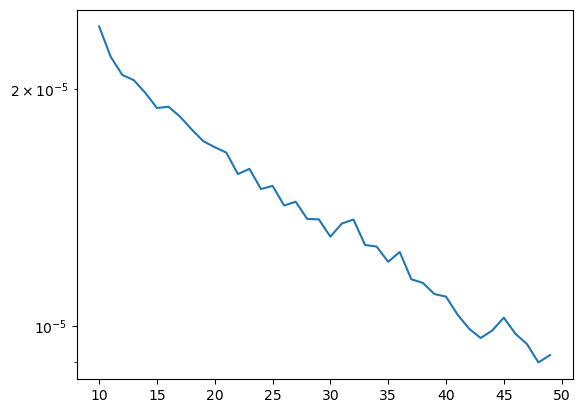

In [68]:
fig, ax = plt.subplots()

ax.plot(history.epoch, history.history["loss"]);
ax.set_yscale("log")

In [130]:
num_points = 201
log_mass = 0.3
log_age = np.linspace(7.0, 10.1 - 3.2 * log_mass, num_points)
example_features = np.stack([
    log_age,
    np.ones(num_points) * log_mass,
    log_age + 3.2 * log_mass,
    np.zeros(num_points),
    np.ones(num_points) * 0.26,
    np.ones(num_points) * 2,
], axis=-1)

example_labels = best_model(example_features).numpy()

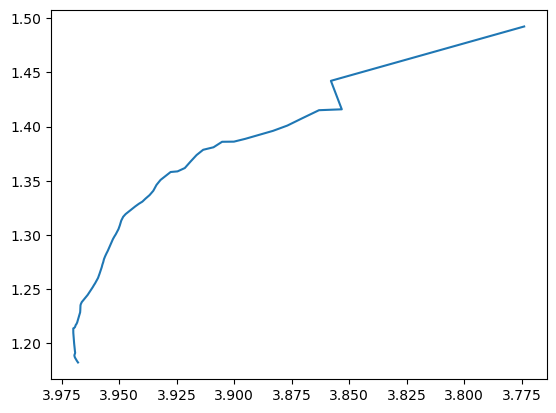

In [131]:
fig, ax = plt.subplots()


log_L = 2 * example_labels[:, 1] + 4 * (example_labels[:, 0] - np.log10(5772.))
ax.plot(example_labels[:, 0], log_L)
ax.invert_xaxis()

In [135]:
train_pred = best_model(train_features)
log_error = train_labels - train_pred.numpy()
error = 10**train_labels - 10**train_pred.numpy()

In [138]:
error.describe()

,log_Teff,log_R,log_Dnu
count,4.983098e+06,4.983098e+06,4.983098e+06
mean,1.730013e+01,1.372712e-02,-1.647497e-01
std,3.915940e+01,8.817898e-02,4.769129e-01
min,-3.569170e+02,-1.796226e+00,-1.952153e+01
25%,-4.599609e+00,-4.359245e-03,-2.379684e-01
50%,1.476123e+01,3.867149e-03,-6.923294e-02
75%,3.575146e+01,1.513779e-02,5.009842e-02
max,4.379512e+02,4.709710e+00,1.223250e+01


Text(0, 0.5, 'log(L/Lsun)')

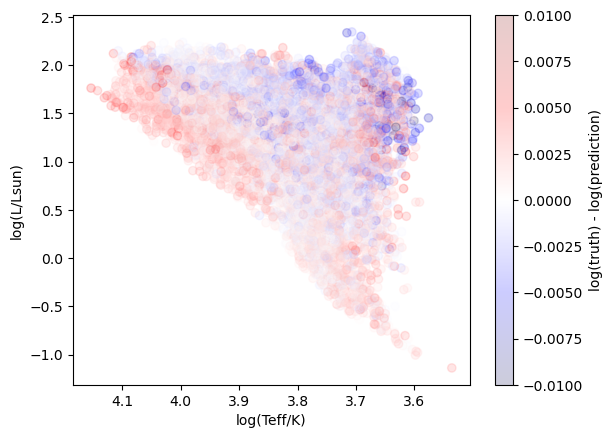

In [133]:
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, data.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.01, vmax=0.01)
fig.colorbar(s, label="log(truth) - log(prediction)")

ax.invert_xaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

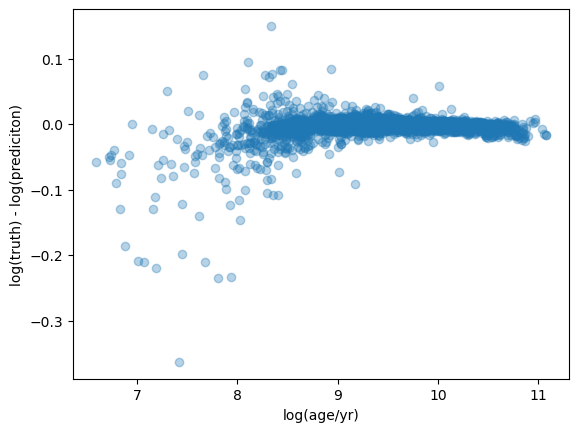

In [80]:
key = "log_age"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(age/yr)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

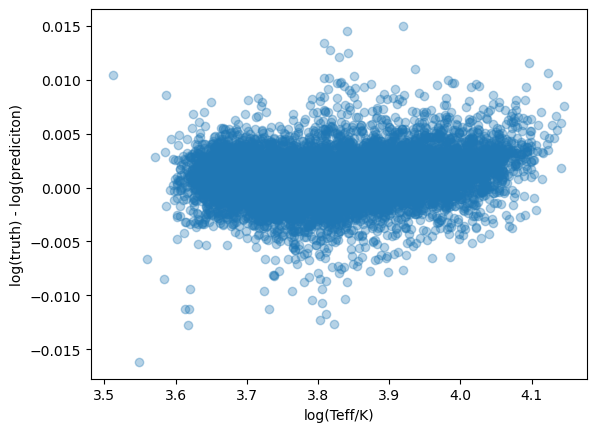

In [134]:
key = "log_Teff"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

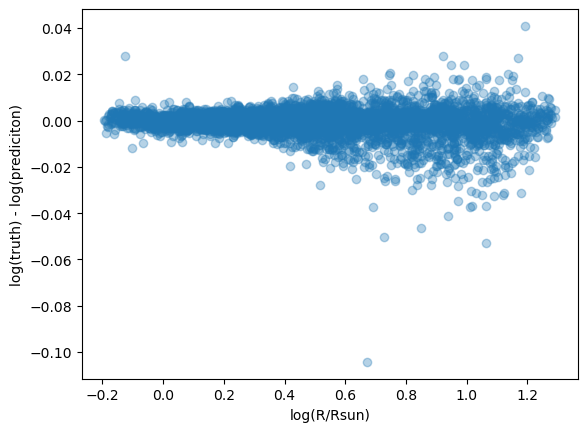

In [82]:
key = "log_R"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(R/Rsun)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

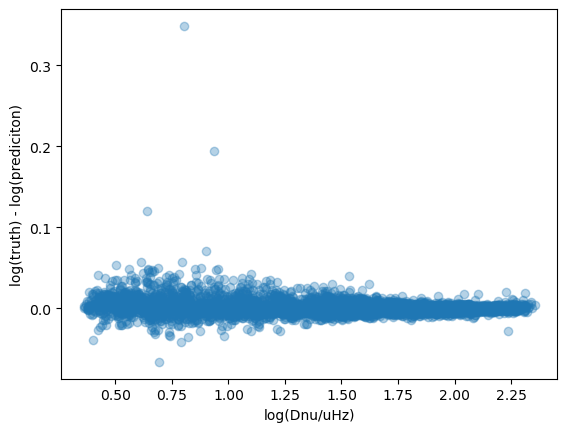

In [84]:
key = "log_Dnu"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(Dnu/uHz)")
ax.set_ylabel("log(truth) - log(prediciton)")

In [88]:
train_pred = pd.DataFrame(train_pred, index=train.index, columns=["log_age", "log_Teff", "log_R", "log_Dnu"])
train_pred["log_L"] = 2 * train_pred["log_R"] + 4 * (train_pred["log_Teff"] - np.log10(5772.))

In [89]:
error = 10**train_labels - 10**train_pred

In [90]:
error.std()

log_Dnu     4.446557e-01
log_L                NaN
log_R       8.597057e-02
log_Teff    2.556183e+01
log_age     1.765172e+08
dtype: float64

In [91]:
(10**train["log_L"] - 10**train_pred["log_L"]).std()

0.8184800403186487

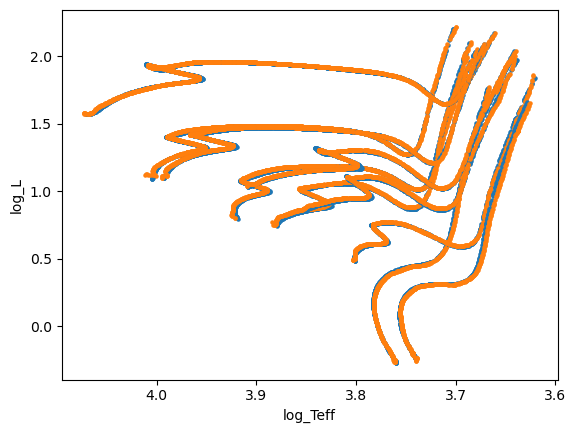

In [92]:
fig, ax = plt.subplots()
for ti in train.track.sample(10, random_state=0):
    mask = train.track == ti
    ax = train.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", marker=".", ax=ax)
    ax = train_pred.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

ax.invert_xaxis();

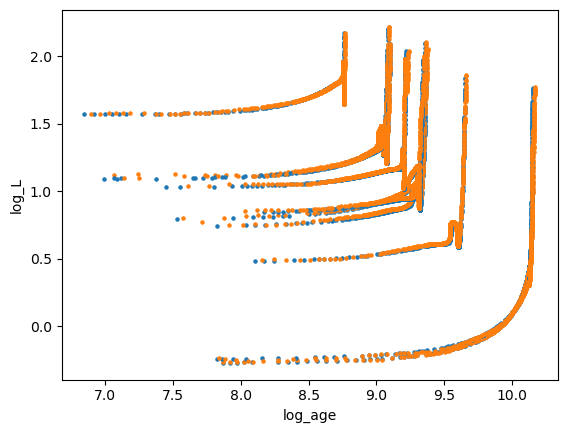

In [93]:
fig, ax = plt.subplots()
for ti in train.track.sample(10, random_state=0):
    mask = train.track == ti
    ax = train.loc[mask].plot(x="log_age", y="log_L", kind="scatter", marker=".", ax=ax)
    ax = train_pred.loc[mask].plot(x="log_age", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

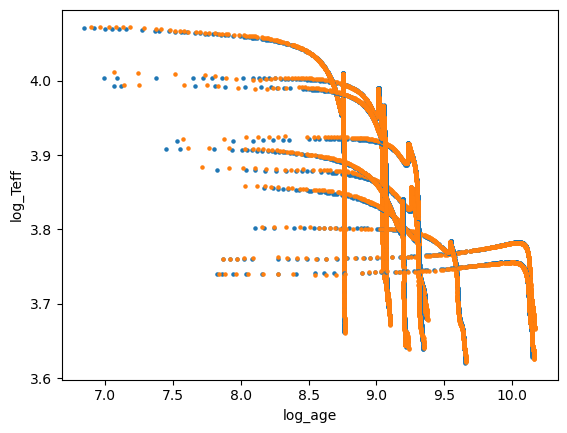

In [94]:
fig, ax = plt.subplots()
for ti in train.track.sample(10, random_state=0):
    mask = train.track == ti
    ax = train.loc[mask].plot(x="log_age", y="log_Teff", kind="scatter", marker=".", ax=ax)
    ax = train_pred.loc[mask].plot(x="log_age", y="log_Teff", kind="scatter", c="C1", marker=".", ax=ax)

In [95]:
filepath = os.path.join(directory, project_name, "best", "model.tf")
best_model.save(filepath)

INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20230627-173049/best/model.tf/assets


In [110]:
import json

In [115]:
history_dict = dict(
    history=history.history,
    params=history.params,
    epoch=history.epoch,
)

In [116]:
with open("test.json", "w") as file:
    s = json.dumps(history_dict)
    file.write(s)

In [ ]:
callbacks.ModelCheckpoint()

In [ ]:
callbacks.EarlyStopping()